In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm as tqdm
import random
import os
import json
import numpy as np

import george
from functools import partial
import scipy.optimize as op
from astropy.table import Table, vstack
from gaussian_process import *

In [2]:
df_ztfrest = pd.read_csv('ZTFReST.csv')
ztfredshifts = df_ztfrest.dropna(subset=["redshift"]).copy().reset_index(drop=True)
df_eval = pd.read_csv('candidateEval07-18.csv')
df_eval = df_eval.dropna(subset=["redshift"]).copy().reset_index(drop=True)

objIds = sorted(list(set(df_eval["object"])))

In [3]:
data_folder = 'data/'
photometry_dict = {}


for root, dirs, files in sorted(os.walk(data_folder)):
    for file in files:
        if file == 'photometry.json':
            folder_name = os.path.basename(root)
            file_path = os.path.join(root, file)
            with open(file_path, 'r') as f:
                photometry_dict[folder_name] = json.load(f)

lc_dict = {key: pd.DataFrame.from_dict(val) for key, val in photometry_dict.items()}
## remove empty lightcurves
lc_dict = {key: val for key, val in lc_dict.items() if not val.empty}

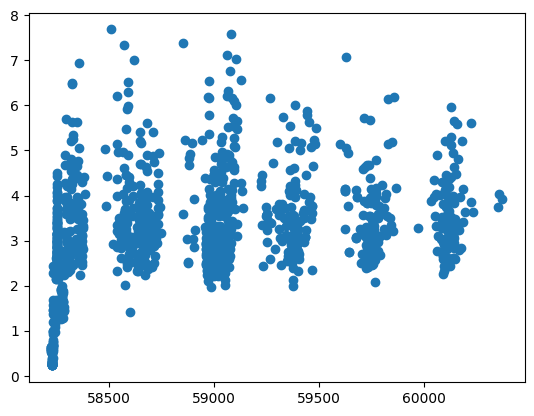

In [4]:
fig, ax = plt.subplots()
ax.scatter(lc_dict['ZTF18aakuewf'].mjd, lc_dict['ZTF18aakuewf'].mag*lc_dict['ZTF18aakuewf'].magerr)

Compile all the objects into one dataframe, with the following columns:
- `id`: the object id
- `class`: the object class
- `redshift`: the redshift of the object
- `mjd`: time of observation
- `mag`: the magnitude of the object
- `mag_err`: the error of the magnitude
- `filter`: the filter of the observation

In [5]:
df_objects = pd.DataFrame(columns=['obj_id', 'type', 'redshift', 'mjd', 'mag', 'magerr', 'filter', 'snr'])

for obj_id in objIds:
    df_lc = lc_dict[obj_id]
    df_lc.dropna(subset=['mag', 'magerr'], inplace=True)
    df_lc['id'] = obj_id
    df_lc = df_lc[['obj_id', 'mjd', 'mag', 'magerr', 'filter', 'snr']]
    df_lc['type'] = df_eval.loc[df_eval['object'] == obj_id, 'class'].values[0]
    df_lc['redshift'] = df_eval.loc[df_eval['object'] == obj_id, 'redshift'].values[0]
    df_objects = pd.concat([df_objects, df_lc])

/tmp/ipykernel_148651/982688885.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lc['type'] = df_eval.loc[df_eval['object'] == obj_id, 'class'].values[0]
/tmp/ipykernel_148651/982688885.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lc['redshift'] = df_eval.loc[df_eval['object'] == obj_id, 'redshift'].values[0]
/tmp/ipykernel_148651/982688885.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [6]:
df_objects = df_objects[(df_objects['filter'] == 'ztfr') | (df_objects['filter'] == 'ztfg') | (df_objects['filter'] == 'ztfi')]
df_objects = df_objects[df_objects['snr']>5]

In [7]:
def Mag2Flux(df):
    df_copy = df.dropna().copy()
    df_copy['flux'] = 10 ** (-0.4 * (df_copy['mag'] - 23.9))
    df_copy['flux_error'] = (df_copy['magerr'] / (2.5 / np.log(10))) * df_copy['flux']

    df_copy = df_copy[['obj_id', 'mjd', 'flux', 'flux_error', 'filter', 'type', 'redshift']]
    return df_copy

def Normalize(df):
    df_copy = df.dropna().copy()
    df_copy['mjd_0'] = df_copy.groupby('obj_id')['mjd'].transform(lambda x: np.min(x))
    df_copy['mjd'] = df_copy.groupby('obj_id')['mjd'].transform(lambda x: x - np.min(x))

    df_copy.reset_index(drop=True, inplace=True)
    return df_copy


In [8]:
flux_df = Mag2Flux(df_objects)
flux_df = flux_df.dropna(subset=['flux', 'flux_error']).copy()
norm_df = Normalize(flux_df)


In [9]:
norm_df

obj_id       mjd        flux  flux_error filter type redshift  \
0     ZTF18aakuewf  0.000000   94.536566    2.762427   ztfr  Ibn   0.0636   
1     ZTF18aakuewf  0.018090  102.621835    2.780158   ztfr  Ibn   0.0636   
2     ZTF18aakuewf  0.038414   97.921932    3.020715   ztfr  Ibn   0.0636   
3     ZTF18aakuewf  0.073924  104.087781    3.031263   ztfr  Ibn   0.0636   
4     ZTF18aakuewf  0.074861  104.761025    3.220689   ztfr  Ibn   0.0636   
...            ...       ...         ...         ...    ...  ...      ...   
5864  ZTF24aascytf  3.190382   26.859287    3.875425   ztfg   II    0.038   
5865  ZTF24aascytf  5.136296   25.594688    4.422032   ztfr   II    0.038   
5866  ZTF24aascytf  9.123403   35.998116    6.552586   ztfr   II    0.038   
5867  ZTF24aascytf  9.123403   35.998749    6.552715   ztfr   II    0.038   
5868  ZTF24aascytf  9.123403   36.231281    4.404822   ztfr   II    0.038   

             mjd_0  
0     58226.340532  
1     58226.340532  
2     58226.340532  
3     58226.340532  
4     58226.340532  
...            ...  
5864  60476.217836  
5865  60476.217836  
5866  60476.217836  
5867  60476.217836  
5868  60476.217836  

[5869 rows x 8 columns]

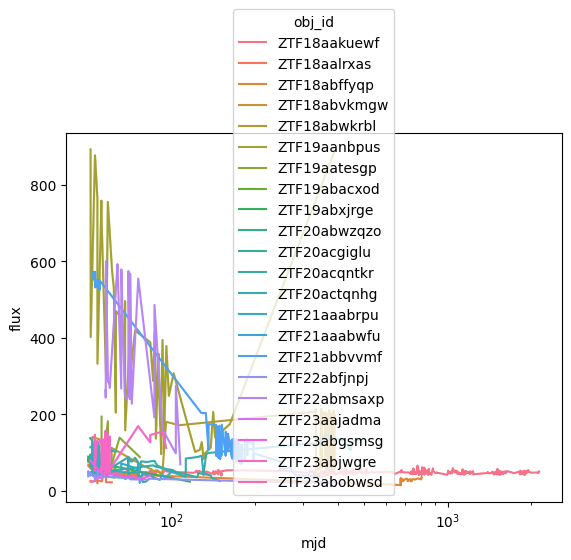

In [10]:
fig, ax = plt.subplots()
sns.lineplot(data=norm_df[norm_df['mjd']>50], x='mjd', y='flux', hue='obj_id', ax=ax)
ax.set_xscale('log')

/tmp/ipykernel_148651/4024913305.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.lineplot(data=norm_df[norm_df['obj_id'].isin(long_objects)][norm_df['mjd']<50][norm_df['obj_id']!='ZTF22abfjnpj'], x='mjd', y='flux', hue='obj_id', ax=ax)


<Axes: xlabel='mjd', ylabel='flux'>

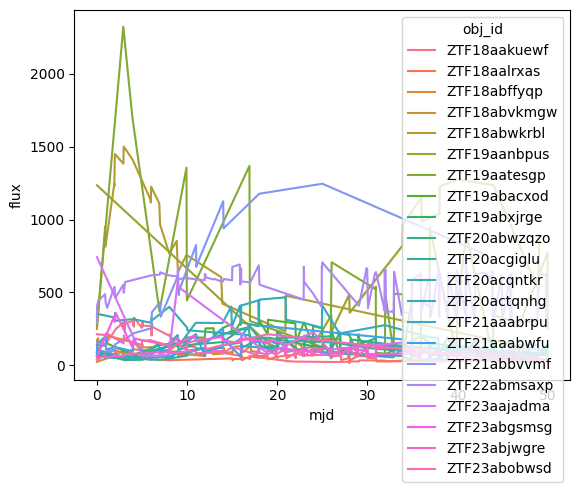

In [11]:
long_objects = norm_df[norm_df.groupby('obj_id')['mjd'].transform('max') > 50]['obj_id'].unique()

fig, ax = plt.subplots()
sns.lineplot(data=norm_df[norm_df['obj_id'].isin(long_objects)][norm_df['mjd']<50][norm_df['obj_id']!='ZTF22abfjnpj'], x='mjd', y='flux', hue='obj_id', ax=ax)

In [12]:
def count_obj_by_type(df):
    obj_id_count_per_type = df.groupby('type')['obj_id'].nunique()
    print(obj_id_count_per_type)

In [13]:
from sklearn.model_selection import GroupShuffleSplit

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

train_idx, test_idx = next(gss.split(norm_df, groups=norm_df['obj_id']))

train_data = norm_df.iloc[train_idx]
test_data = norm_df.iloc[test_idx]

In [14]:
count_obj_by_type(train_data)
count_obj_by_type(test_data)

type
Cataclysmic                9
FBOT                       2
GRB                        1
II                         6
IIP                        1
IIb                       14
Ia                         3
Ib                         3
Ib/c;Ib-pec                1
Ibn                        2
Novae                      3
Novae;Classical Nova       4
Tidal Disruption Event     1
U Gem                      1
afterglow                  2
afterglow; Ic-BL           1
long GRB                   4
Name: obj_id, dtype: int64
type
Cataclysmic         1
II                  2
IIb                 6
Ia                  2
Ibn                 1
Ic-BL               1
Novae               1
afterglow; Ic-BL    1
Name: obj_id, dtype: int64


In [15]:
pb_wavelengths = {
    'ztfg': 4800.,
    'ztfr': 6400.,
    'ztfi': 7900.,
}

filters = ['ztfg', 'ztfr', 'ztfi']

gp_wavelengths = np.vectorize(pb_wavelengths.get)(filters)

inverse_gp_wavelengths = {v: k for k, v in pb_wavelengths.items()}

# These functions are taken from the 'Paying Attention to Astronomical Transients' paper

def fit_2d_gp(obj_data, kernel=None, return_kernel=False, global_fit=False, **kwargs):
    if kernel is None:
        guess_length_scale = 20.0
        signal_to_noises = np.abs(obj_data.flux) / np.sqrt(
            obj_data.flux_error ** 2 + (1e-2 * np.max(obj_data.flux)) ** 2
        )
        scale = np.abs(obj_data.flux[signal_to_noises.idxmax()])
        kernel = (0.5 * scale) ** 2 * george.kernels.Matern32Kernel([
            guess_length_scale ** 2, 6000 ** 2], ndim=2)
        kernel.freeze_parameter("k2:metric:log_M_1_1")


    obj_times = obj_data.mjd.astype(float)
    obj_flux = obj_data.flux.astype(float)
    obj_flux_error = obj_data.flux_error.astype(float)
    obj_wavelengths = obj_data['filter'].map(pb_wavelengths)

    def neg_log_like(p):  # Objective function: negative log-likelihood
        gp.set_parameter_vector(p)
        loglike = gp.log_likelihood(obj_flux, quiet=True)
        return -loglike if np.isfinite(loglike) else 1e25

    def grad_neg_log_like(p):  # Gradient of the objective function.
        gp.set_parameter_vector(p)
        return -gp.grad_log_likelihood(obj_flux, quiet=True)

    gp = george.GP(kernel)
    default_gp_param = gp.get_parameter_vector()
    x_data = np.vstack([obj_times, obj_wavelengths]).T
    gp.compute(x_data, obj_flux_error)

    bounds = [(0, np.log(1000 ** 2))]
    bounds = [(default_gp_param[0] - 10, default_gp_param[0] + 10)] + bounds
    results = op.minimize(neg_log_like, gp.get_parameter_vector(),
                          jac=grad_neg_log_like, method="L-BFGS-B",
                          bounds=bounds, tol=1e-6)

    if results.success:
        gp.set_parameter_vector(results.x)
    else:
        # Fit failed. Print out a warning, and use the initial guesses for fit
        # parameters.
        obj = obj_data['obj_id'][0]
        print("GP fit failed for {}! Using guessed GP parameters.".format(obj))
        gp.set_parameter_vector(default_gp_param)

    gp_predict = partial(gp.predict, obj_flux)

    if return_kernel:
        return kernel, gp_predict
    else:
        return gp_predict


def predict_2d_gp(gp_predict, gp_times, gp_wavelengths):
    """Outputs the predictions of a Gaussian Process.

    Parameters
    ----------
    gp_predict : functools.partial of george.gp.GP
        The GP instance that was used to fit the object.
    gp_times : numpy.ndarray
        Times to evaluate the Gaussian Process at.
    gp_wavelengths : numpy.ndarray
        Wavelengths to evaluate the Gaussian Process at.

    Returns
    -------
    obj_gps : pandas.core.frame.DataFrame, optional
        Time, flux and flux error of the fitted Gaussian Process.
    """
    unique_wavelengths = np.unique(gp_wavelengths)
    number_gp = len(gp_times)
    obj_gps = []
    for wavelength in unique_wavelengths:
        gp_wavelengths = np.ones(number_gp) * wavelength
        pred_x_data = np.vstack([gp_times, gp_wavelengths]).T
        pb_pred, pb_pred_var = gp_predict(pred_x_data, return_var=True)
        # stack the GP results in a array momentarily
        obj_gp_pb_array = np.column_stack((gp_times, pb_pred, np.sqrt(pb_pred_var)))
        obj_gp_pb = Table(
            [
                obj_gp_pb_array[:, 0],
                obj_gp_pb_array[:, 1],
                obj_gp_pb_array[:, 2],
                [wavelength] * number_gp,
            ],
            names=["mjd", "flux", "flux_error", "filter"],
        )
        if len(obj_gps) == 0:  # initialize the table for 1st passband
            obj_gps = obj_gp_pb
        else:  # add more entries to the table
            obj_gps = vstack((obj_gps, obj_gp_pb))
            
    obj_gps = obj_gps.to_pandas()
    return obj_gps

def process_gaussian(df, kernel=None, number_gp=100, save=False, name=''):
    
    res_df = pd.DataFrame()

    for obj_id in tqdm.tqdm(df['obj_id'].unique()):
        obj_df = df[df['obj_id'] == obj_id]
        type_obj = obj_df['type'].values[0]
        mjd_0 = obj_df['mjd_0'].values[0]
        redshift = obj_df['redshift'].values[0]
        obj_df.reset_index(drop=True, inplace=True)

        available_filters = obj_df['filter'].unique()
        gp_wavelengths = np.vectorize(pb_wavelengths.get)(available_filters)
        inverse_gp_wavelengths = {v: k for k, v in pb_wavelengths.items() if k in available_filters}
        gp_predict = fit_2d_gp(obj_df, kernel=kernel)
        gp_times = np.linspace(min(obj_df['mjd']), max(obj_df['mjd']), number_gp)

        obj_gps = predict_2d_gp(gp_predict, gp_times, gp_wavelengths)
        obj_gps['filter'] = obj_gps['filter'].map(inverse_gp_wavelengths)

        obj_gps = obj_gps.pivot_table(index=['mjd'], columns='filter', values=['flux', 'flux_error'])
        obj_gps = obj_gps.reset_index()
        obj_gps.columns = [col[0] if col[0] == 'mjd' else '_'.join(col).strip() for col in obj_gps.columns.values]
        obj_gps['type'] = type_obj
        obj_gps['obj_id'] = obj_id
        obj_gps['mjd_0'] = mjd_0
        obj_gps['redshift'] = redshift

        res_df = pd.concat([res_df, obj_gps])

    res_df.reset_index(drop=True, inplace=True)

    if save:
        #types_str = '_'.join(df['type'].unique()) if hasattr(df['type'].unique(), '__iter__') else str(df['type'].unique())
        #filename = f'{name}_gp_{types_str}.csv'
        num_types_str = str(len(df['type'].unique()))
        filename = f'{name}_gp_n{num_types_str}.csv'
        filename = filename.replace(' ', '_')
        res_df.to_csv(filename, index=False)
        print(f'File {filename} saved successfully')
    return res_df

def save_kernel(kernel, filename):
    with open(filename, 'wb') as f:
        pickle.dump(kernel, f)
    print(f'Kernel saved to {filename}')

def load_kernel(filename):
    with open(filename, 'rb') as f:
        kernel = pickle.load(f)
    print(f'Kernel loaded from {filename}')
    return kernel

In [16]:
kernel = load_kernel('kernel.pkl')

Kernel loaded from kernel.pkl


In [17]:
test_results = process_gaussian(test_data, kernel=kernel, save=True, name='test')
train_results = process_gaussian(train_data, kernel=kernel, save=True, name='train')
total_results = process_gaussian(norm_df[norm_df['mjd']<50], kernel=kernel, save=True, name='total')

100%|██████████| 15/15 [00:03<00:00,  4.59it/s]


File test_gp_n8.csv saved successfully


100%|██████████| 58/58 [00:03<00:00, 17.47it/s]


File train_gp_n17.csv saved successfully


100%|██████████| 73/73 [00:03<00:00, 23.61it/s]

File total_gp_n18.csv saved successfully


In [18]:
total_results[total_results['obj_id'] == 'ZTF18aakuewf']


mjd   flux_ztfg   flux_ztfr  flux_error_ztfg  flux_error_ztfr type  \
0    0.000000  136.476566   99.008275        20.225414         1.245730  Ibn   
1    0.504350  162.972272  126.219481        16.229688         2.778614  Ibn   
2    1.008700  190.825310  153.363912        12.014731         3.524496  Ibn   
3    1.513051  219.423324  180.399970         7.692804         4.826813  Ibn   
4    2.017401  248.089537  206.392050         4.061100         5.478884  Ibn   
..        ...         ...         ...              ...              ...  ...   
95  47.913270   44.010812   40.803742         1.617675        37.122970  Ibn   
96  48.417621   44.654114   41.162778         2.572388        37.137935  Ibn   
97  48.921971   44.140985   41.357818         2.581204        37.184834  Ibn   
98  49.426321   44.028659   41.370746         3.051857        37.311670  Ibn   
99  49.930671   44.136408   41.210814         3.105636        37.622328  Ibn   

          obj_id         mjd_0 redshift  flux_ztfi  flux_error_ztfi  
0   ZTF18aakuewf  58226.340532   0.0636        NaN              NaN  
1   ZTF18aakuewf  58226.340532   0.0636        NaN              NaN  
2   ZTF18aakuewf  58226.340532   0.0636        NaN              NaN  
3   ZTF18aakuewf  58226.340532   0.0636        NaN              NaN  
4   ZTF18aakuewf  58226.340532   0.0636        NaN              NaN  
..           ...           ...      ...        ...              ...  
95  ZTF18aakuewf  58226.340532   0.0636        NaN              NaN  
96  ZTF18aakuewf  58226.340532   0.0636        NaN              NaN  
97  ZTF18aakuewf  58226.340532   0.0636        NaN              NaN  
98  ZTF18aakuewf  58226.340532   0.0636        NaN              NaN  
99  ZTF18aakuewf  58226.340532   0.0636        NaN              NaN  

[100 rows x 11 columns]

In [19]:
color_dict = {'ztfg': 'green', 'ztfr': 'red', 'ztfi': 'yellow'}
def plot_gp(obj_model, number_col=4, show_title=True, show_legend=True):
    color_dict = {'ztfg': 'green', 'ztfr': 'red', 'ztfi': 'yellow'}
    f, ax = plt.subplots(figsize=(10, 6))
    ax.set_xlabel('Time (mjd)')
    ax.set_ylabel('Flux') 
    if show_title:
        obj_id = obj_model['obj_id'].iloc[0]
        ax.set_title(f'Light Curve for Object ID: {obj_id} | Type: {obj_model["type"].iloc[0]}')
    if show_legend:
        ax.legend(ncol=number_col)

    # Plotting model data if available
    if obj_model is not None:
        # Iterate over the filters present in the obj_model DataFrame
        for column in obj_model.columns:
            if 'flux' in column and column != 'mjd':
                filter_name = column.split('_')[1]
                if filter_name in color_dict:
                    if not all(obj_model[column] == -1):
                        ax.plot(obj_model['mjd'], obj_model[column], label=f'Model {filter_name}', color=color_dict[filter_name])
    
                        # Plot error band if error data is available
                        error_column = f'flux_error_{filter_name}'
                        if error_column in obj_model.columns:
                            model_flux_error = obj_model[error_column]
                            ax.fill_between(obj_model['mjd'], obj_model[column]-model_flux_error, obj_model[column]+model_flux_error, color=color_dict[filter_name], alpha=0.20)

    return f,ax

In [20]:
total_results

mjd   flux_ztfg   flux_ztfr  flux_error_ztfg  flux_error_ztfr type  \
0     0.000000  136.476566   99.008275        20.225414         1.245730  Ibn   
1     0.504350  162.972272  126.219481        16.229688         2.778614  Ibn   
2     1.008700  190.825310  153.363912        12.014731         3.524496  Ibn   
3     1.513051  219.423324  180.399970         7.692804         4.826813  Ibn   
4     2.017401  248.089537  206.392050         4.061100         5.478884  Ibn   
...        ...         ...         ...              ...              ...  ...   
7196  8.754780   32.991076   35.778804        22.383172        12.391853   II   
7197  8.846936   33.120805   35.975863        21.500098         9.773389   II   
7198  8.939092   33.177963   36.087816        20.818900         7.085820   II   
7199  9.031247   33.157022   36.099820        20.391462         4.547957   II   
7200  9.123403   33.054302   35.995481        20.256452         3.185979   II   

            obj_id         mjd_0 redshift  flux_ztfi  flux_error_ztfi  
0     ZTF18aakuewf  58226.340532   0.0636        NaN              NaN  
1     ZTF18aakuewf  58226.340532   0.0636        NaN              NaN  
2     ZTF18aakuewf  58226.340532   0.0636        NaN              NaN  
3     ZTF18aakuewf  58226.340532   0.0636        NaN              NaN  
4     ZTF18aakuewf  58226.340532   0.0636        NaN              NaN  
...            ...           ...      ...        ...              ...  
7196  ZTF24aascytf  60476.217836    0.038  33.941007        21.548910  
7197  ZTF24aascytf  60476.217836    0.038  34.034440        20.594324  
7198  ZTF24aascytf  60476.217836    0.038  34.056312        19.852856  
7199  ZTF24aascytf  60476.217836    0.038  34.000498        19.384630  
7200  ZTF24aascytf  60476.217836    0.038  33.862840        19.235181  

[7201 rows x 11 columns]

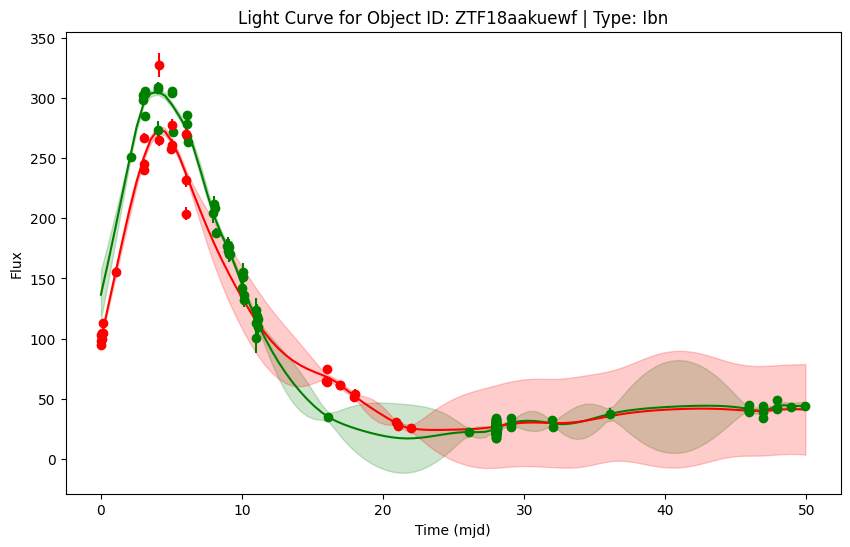

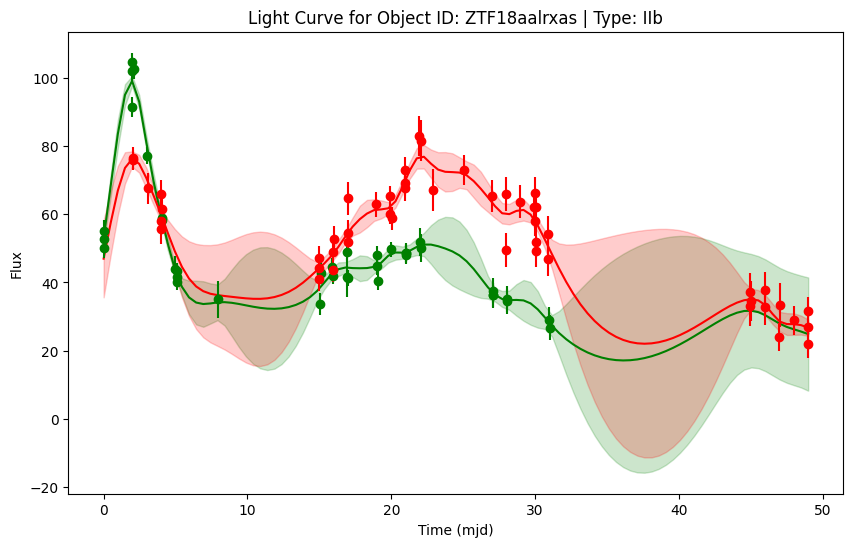

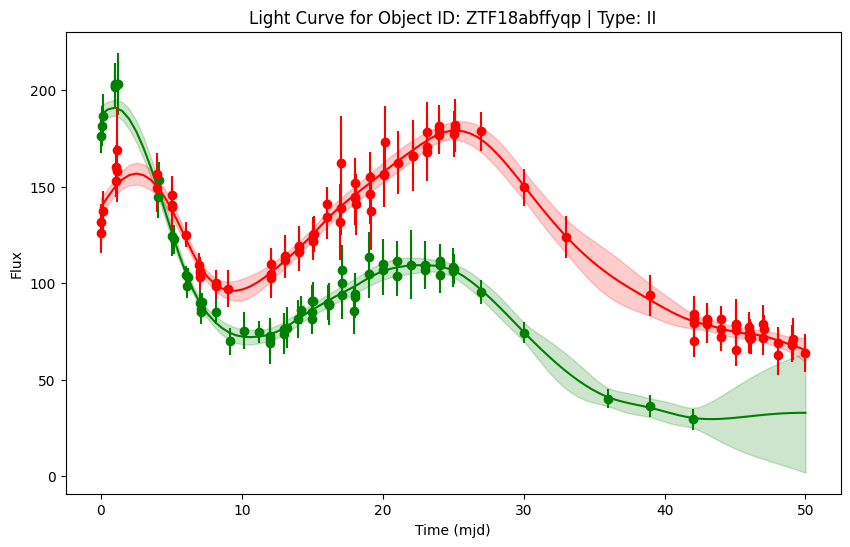

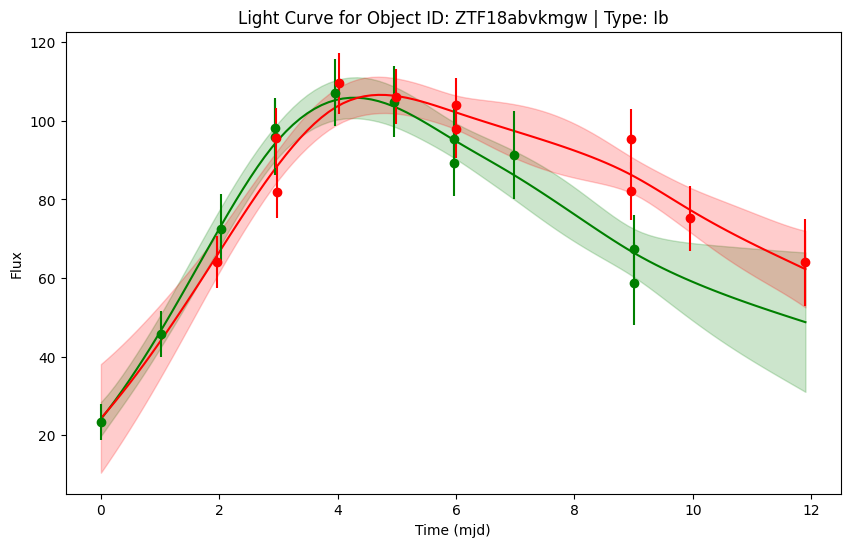

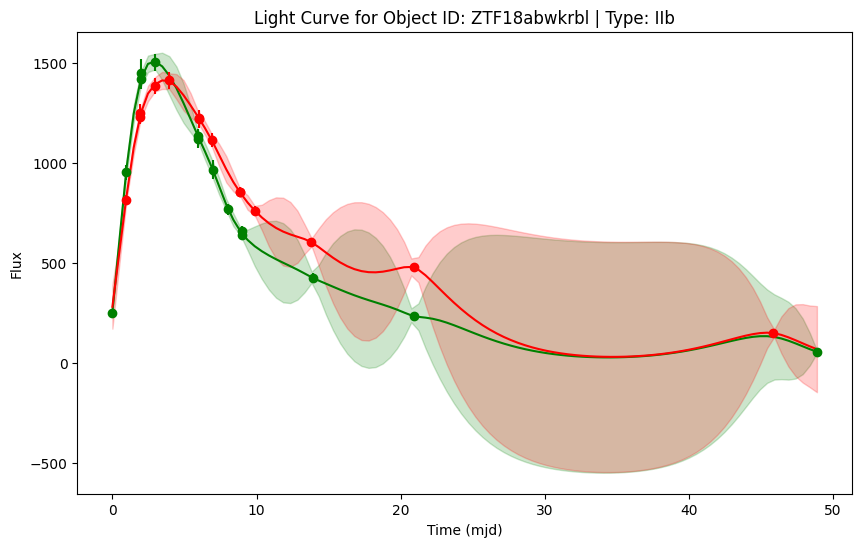

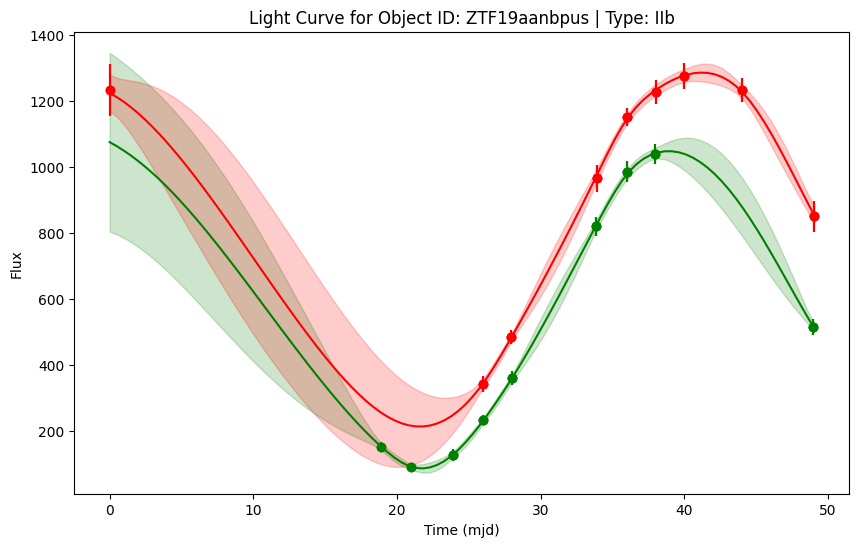

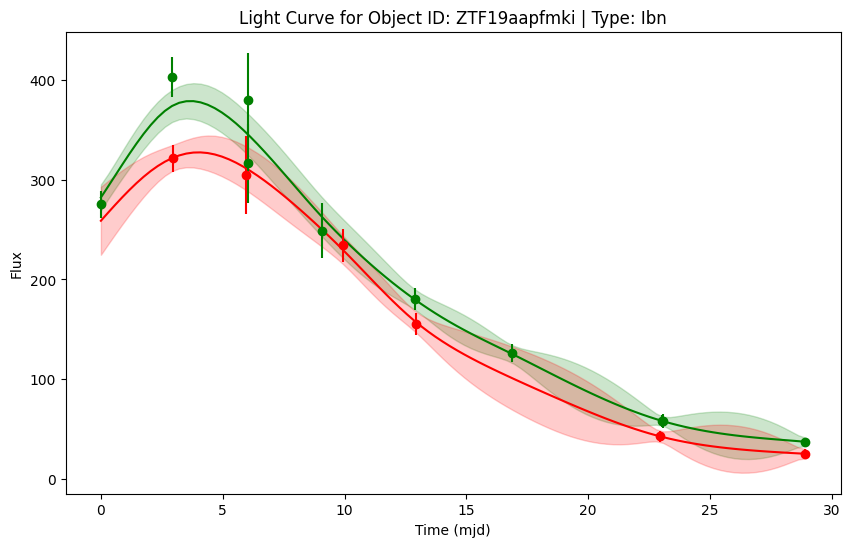

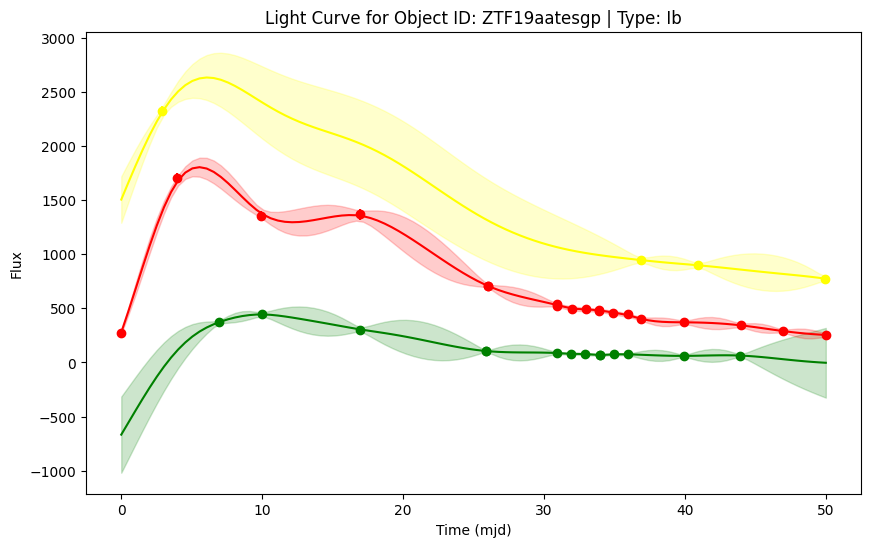

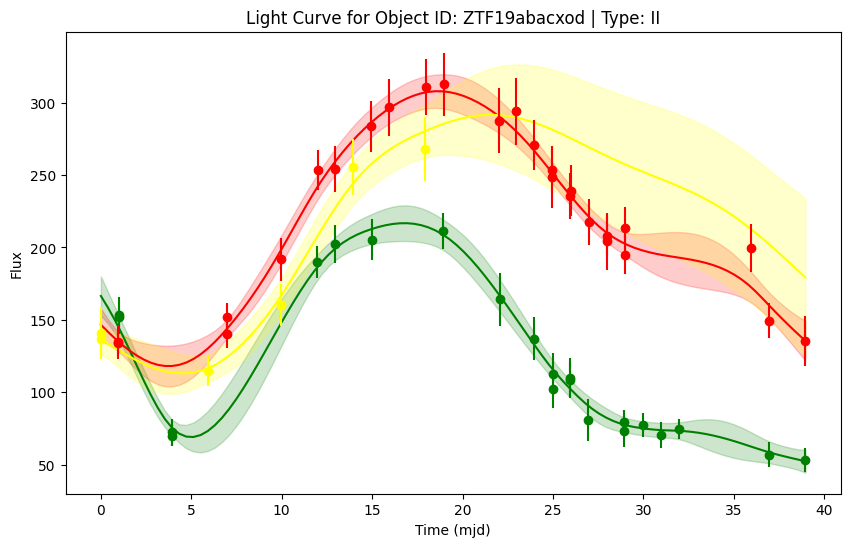

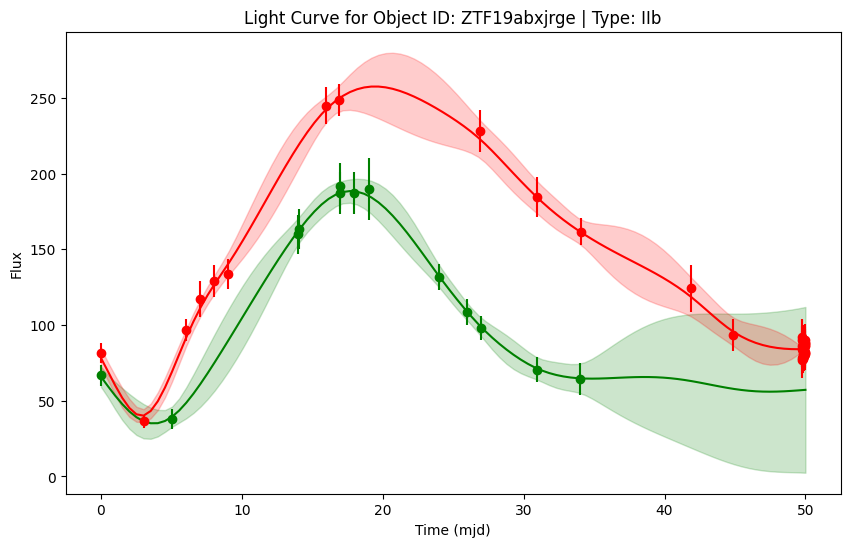

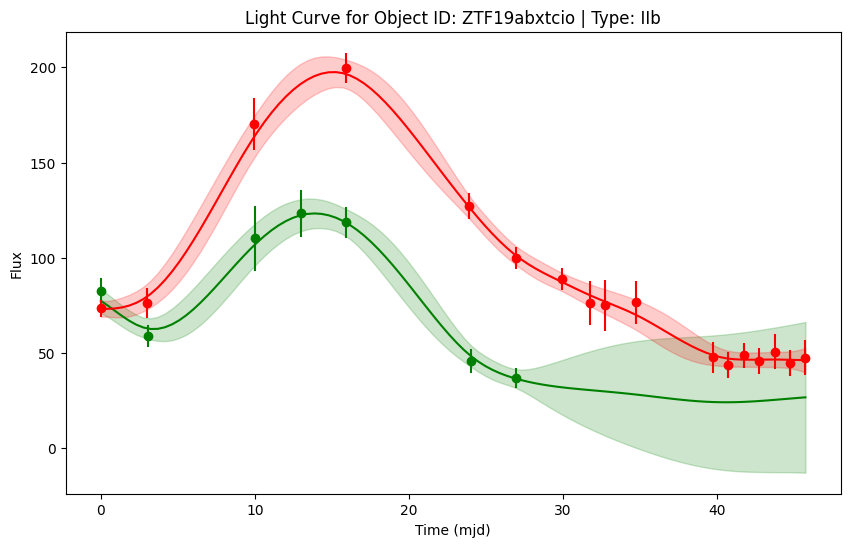

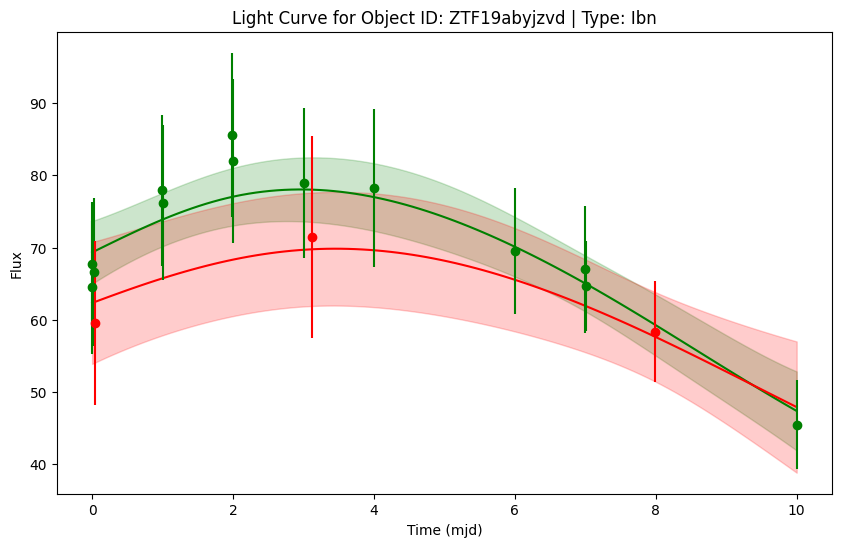

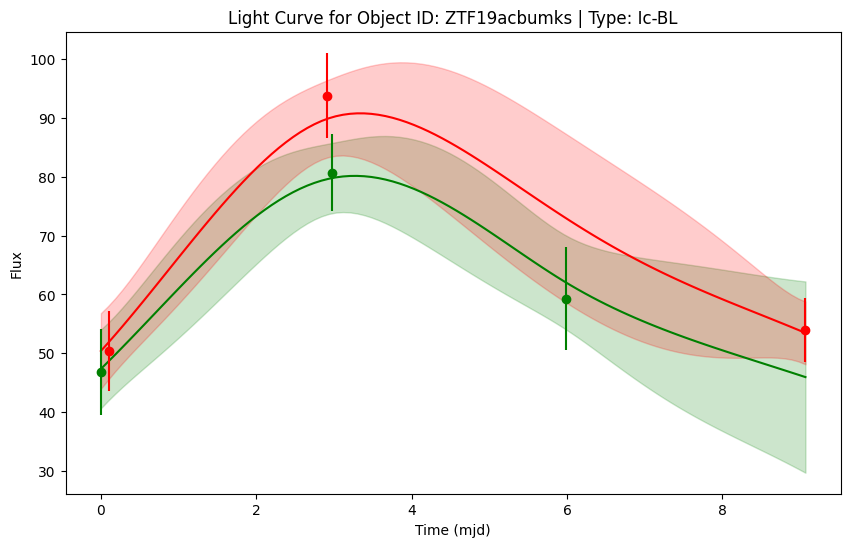

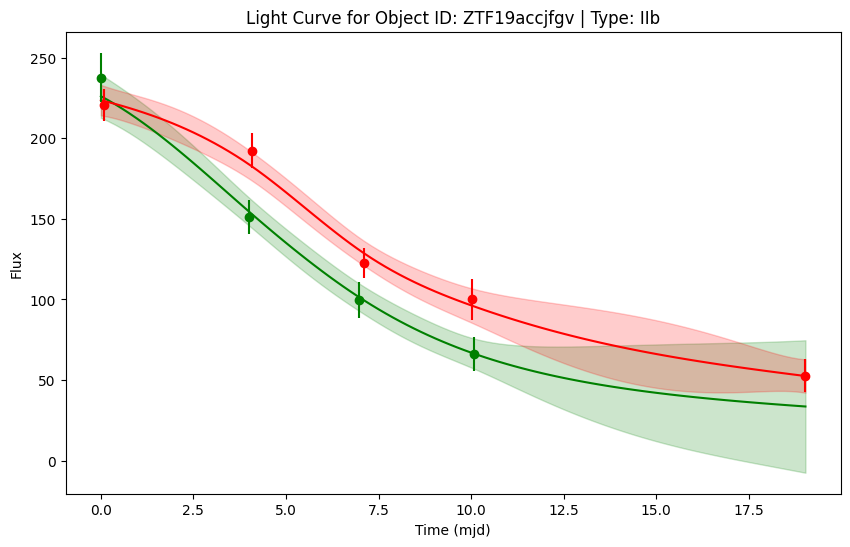

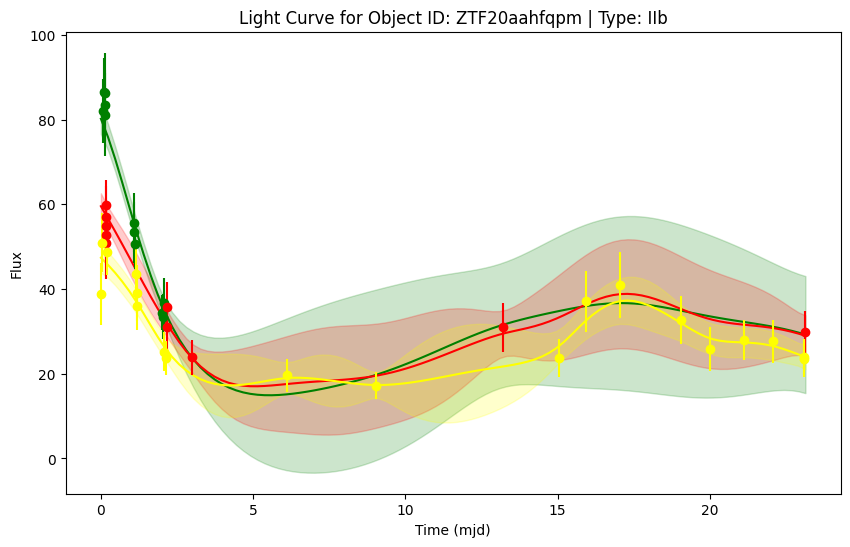

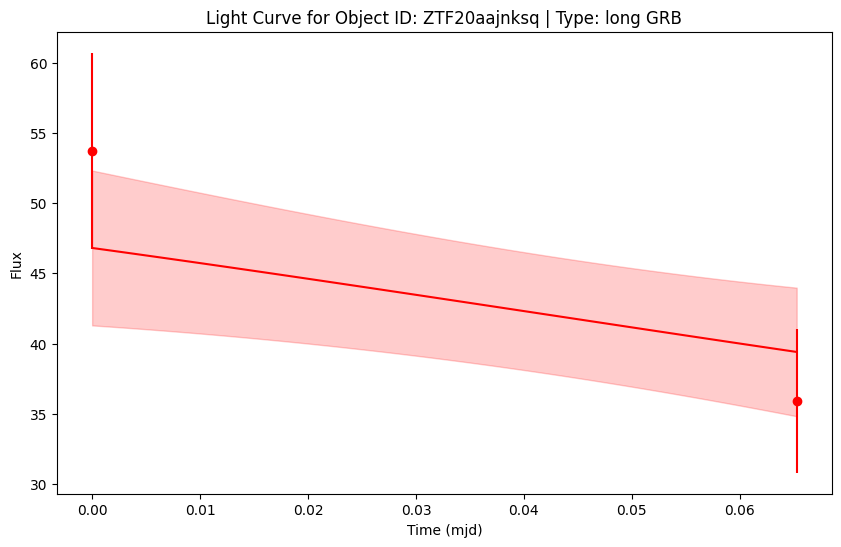

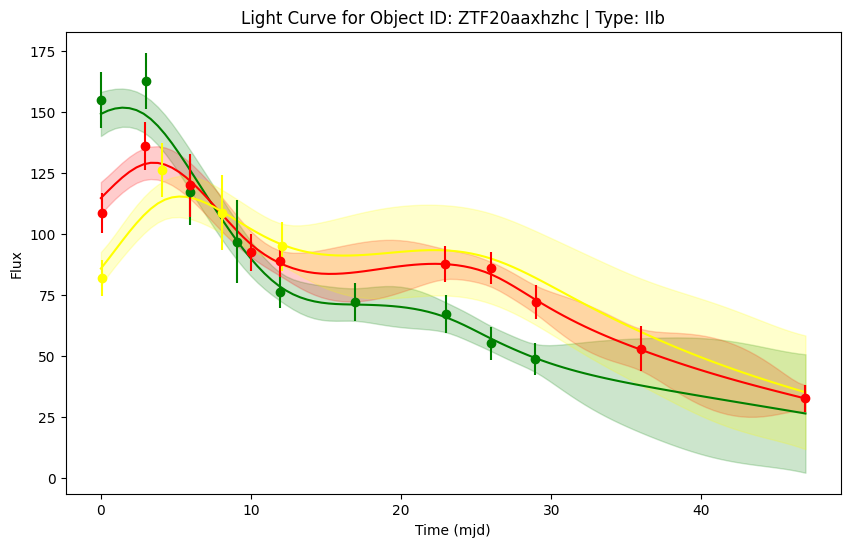

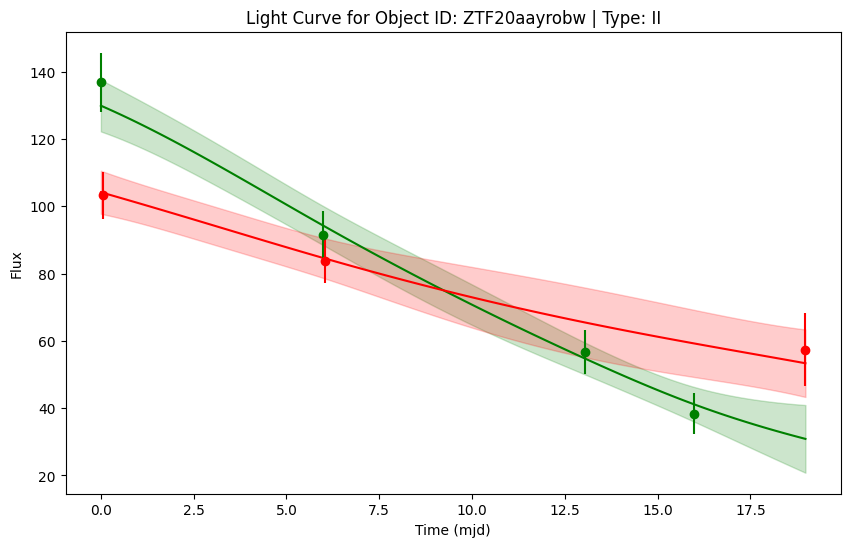

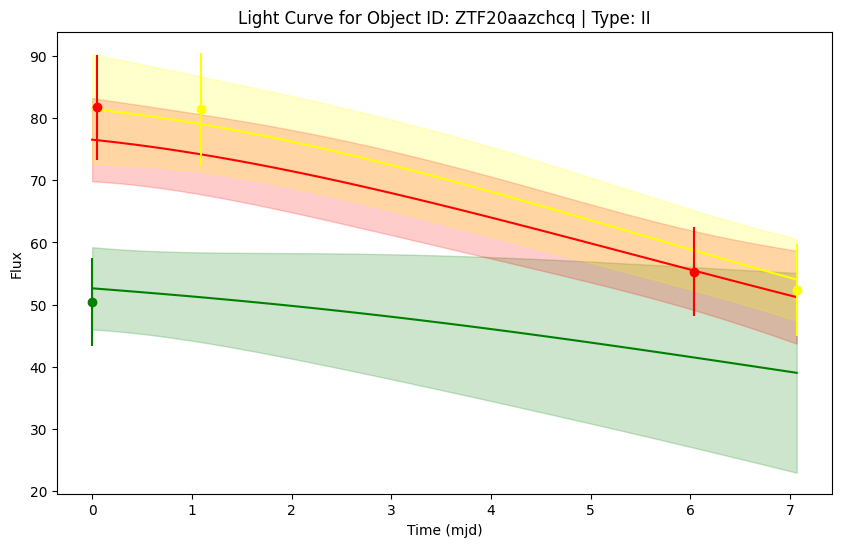

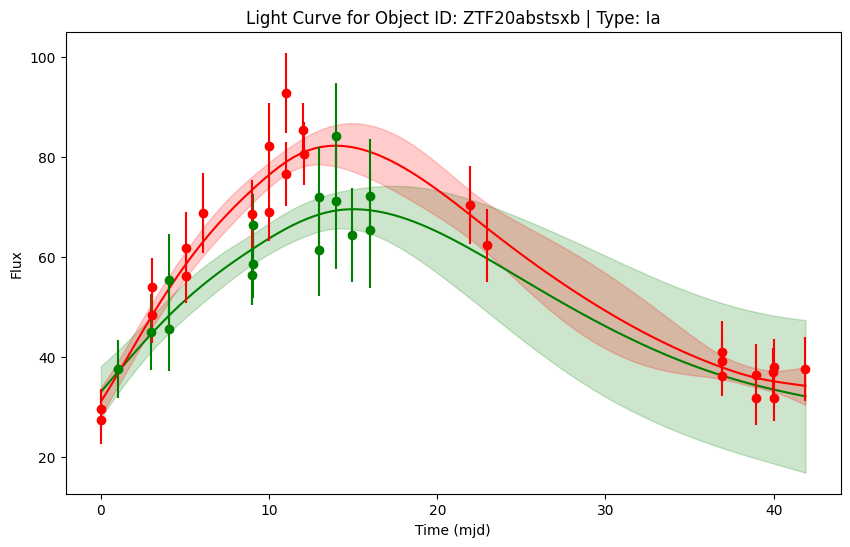

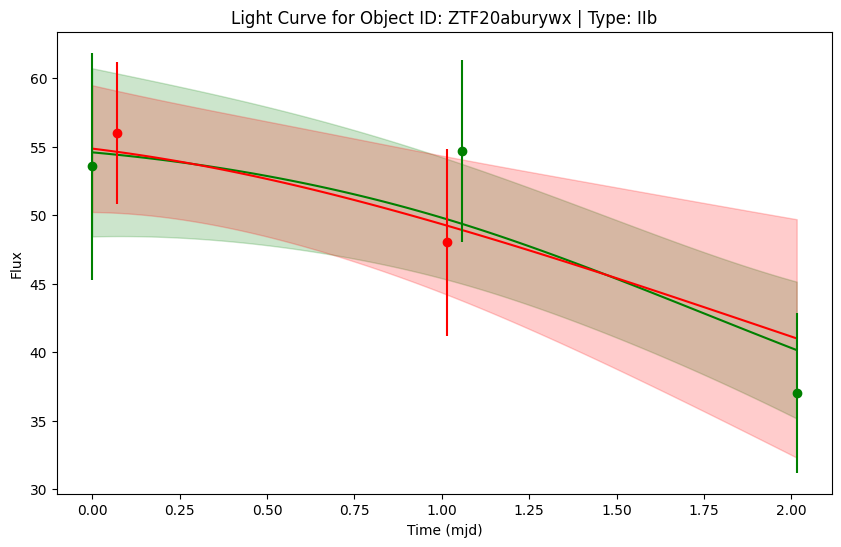

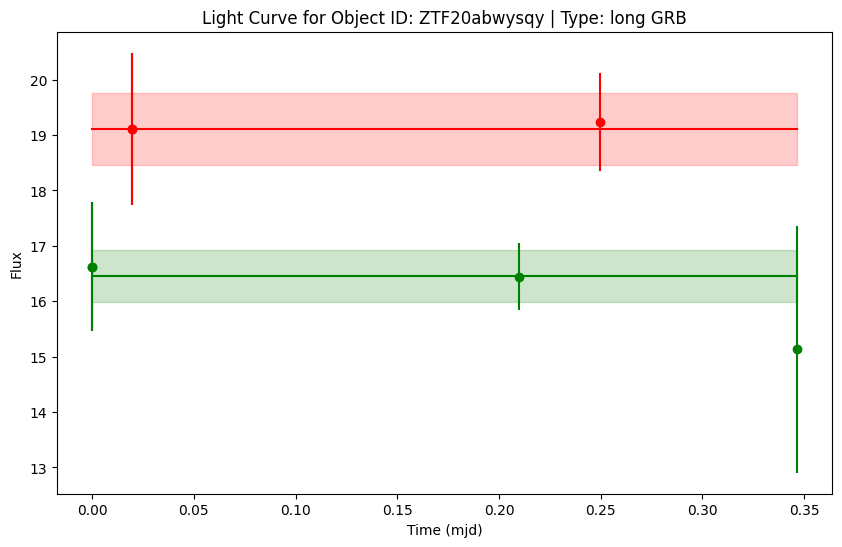

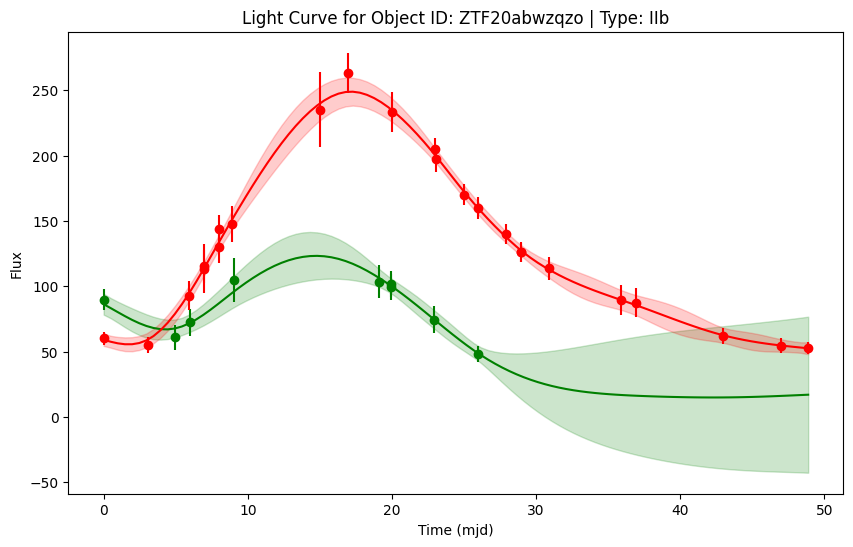

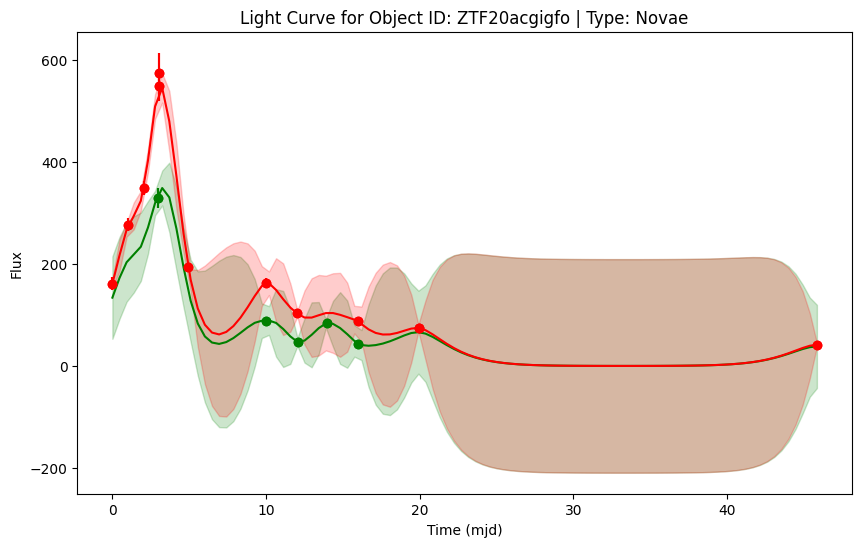

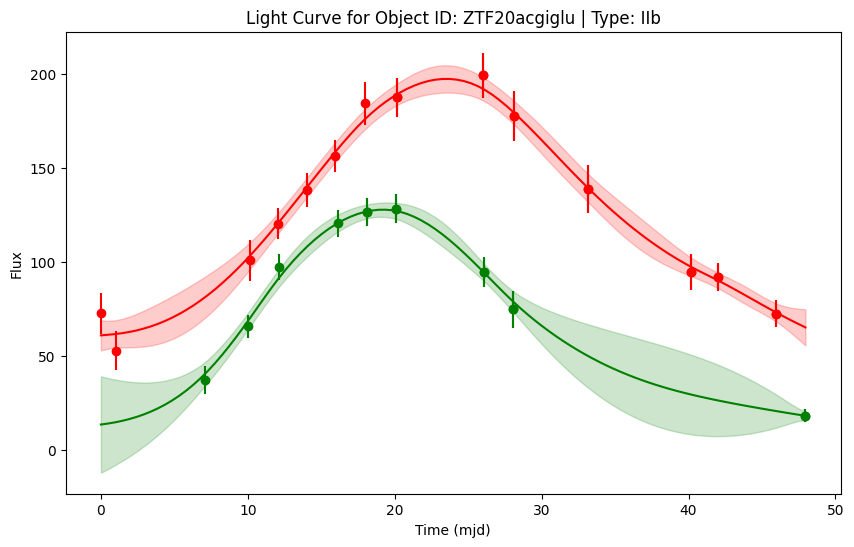

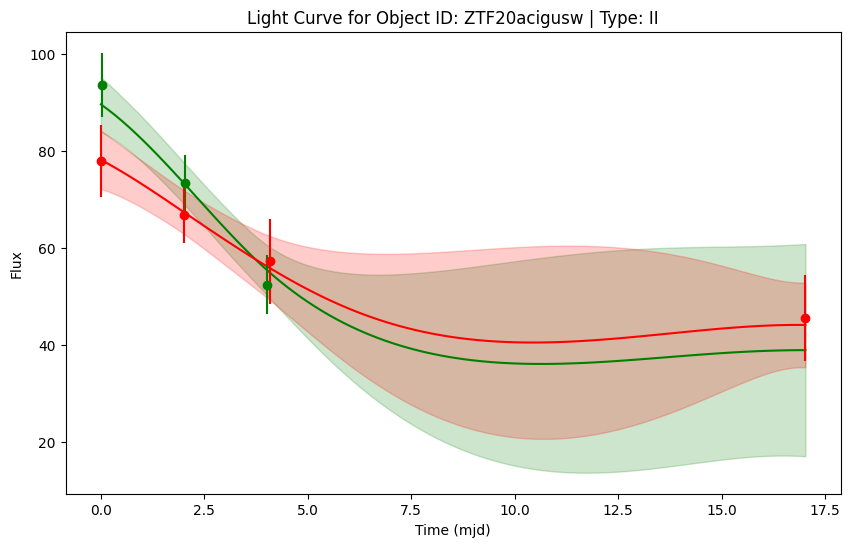

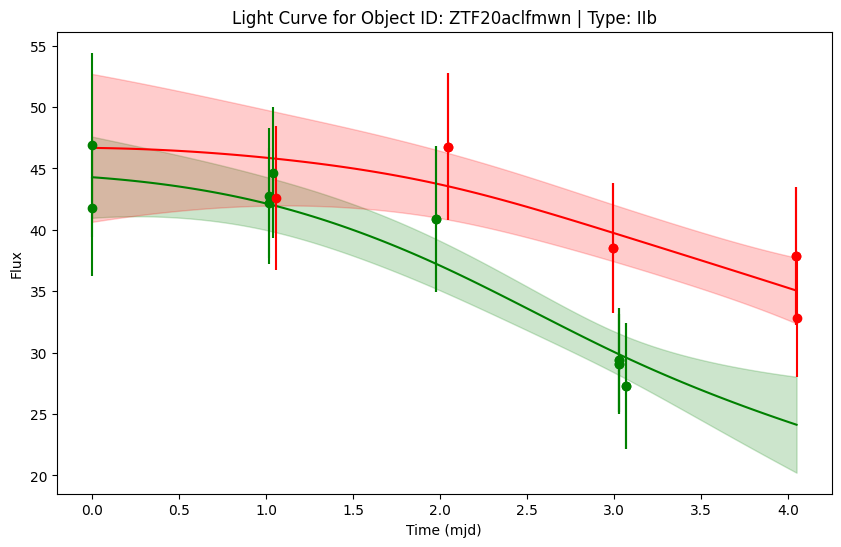

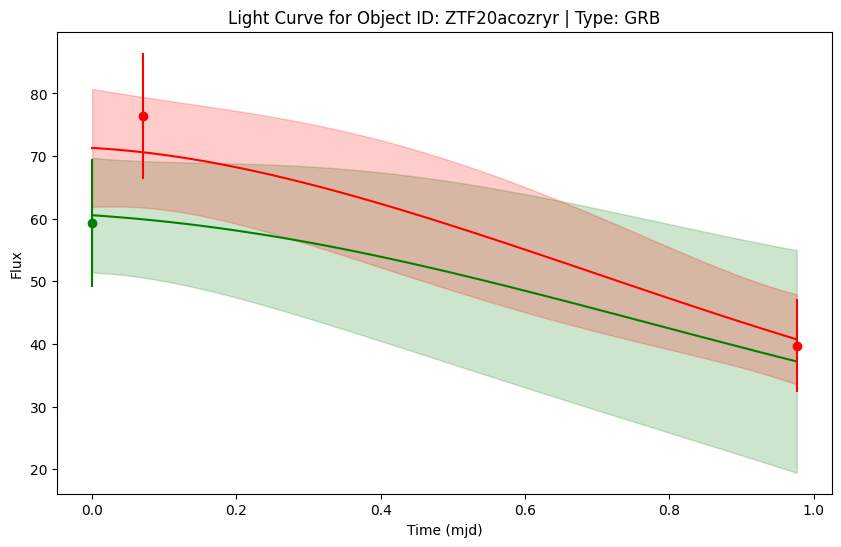

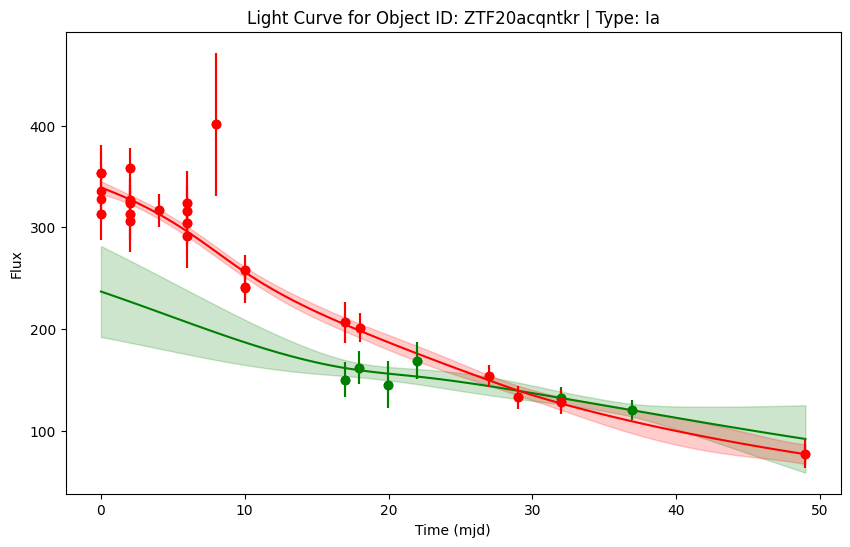

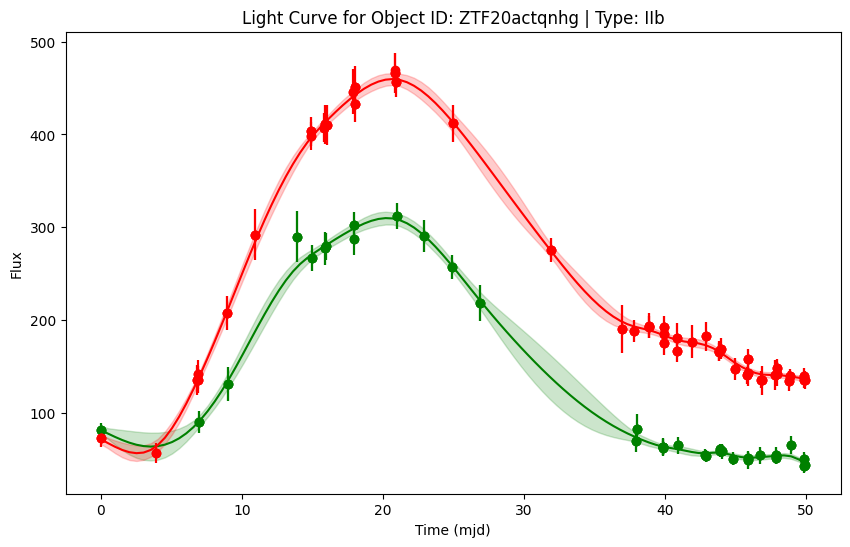

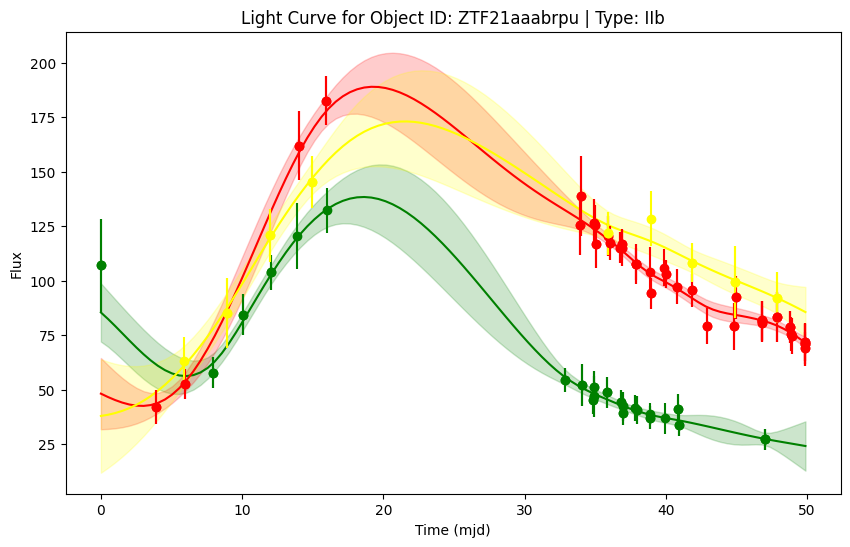

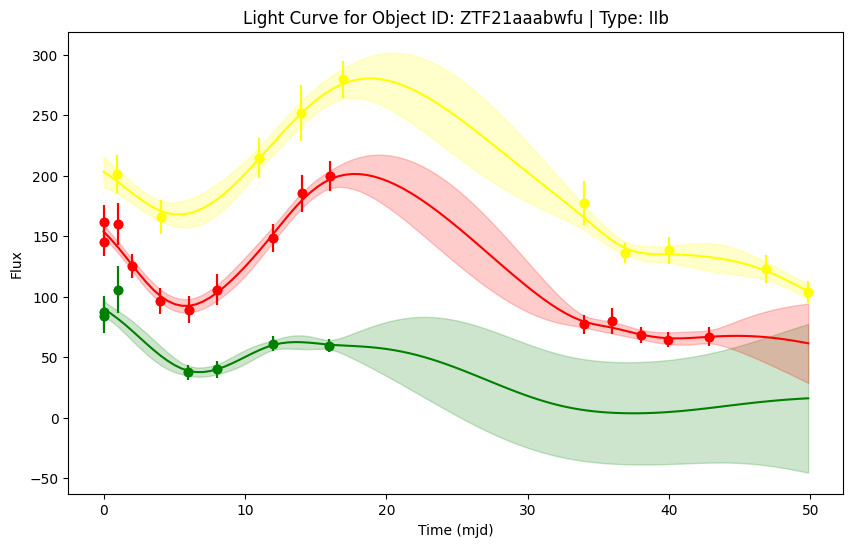

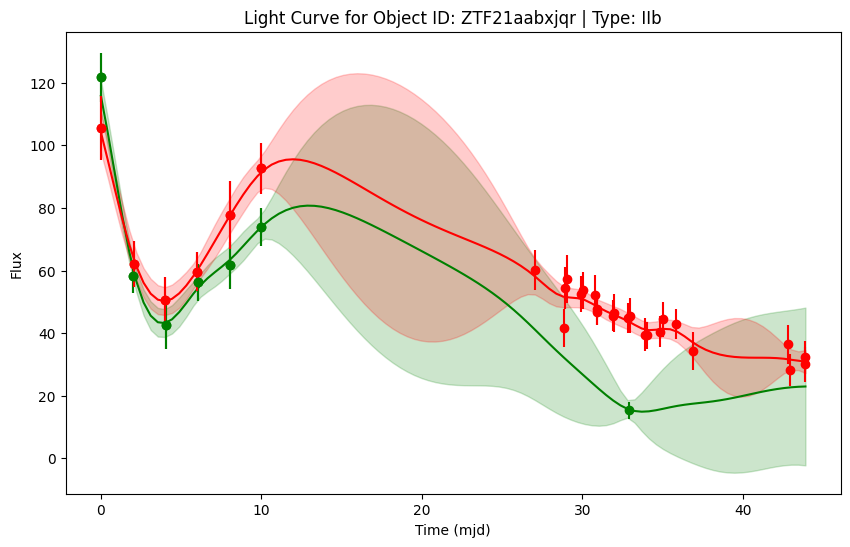

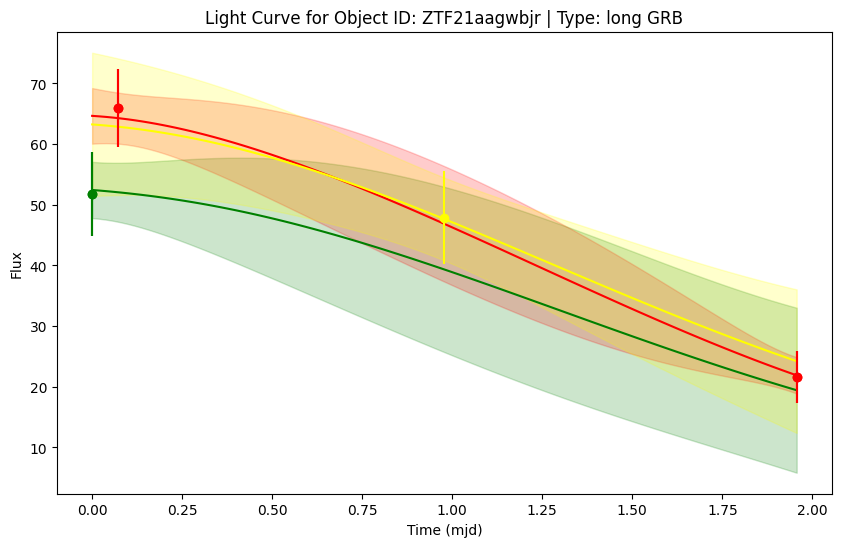

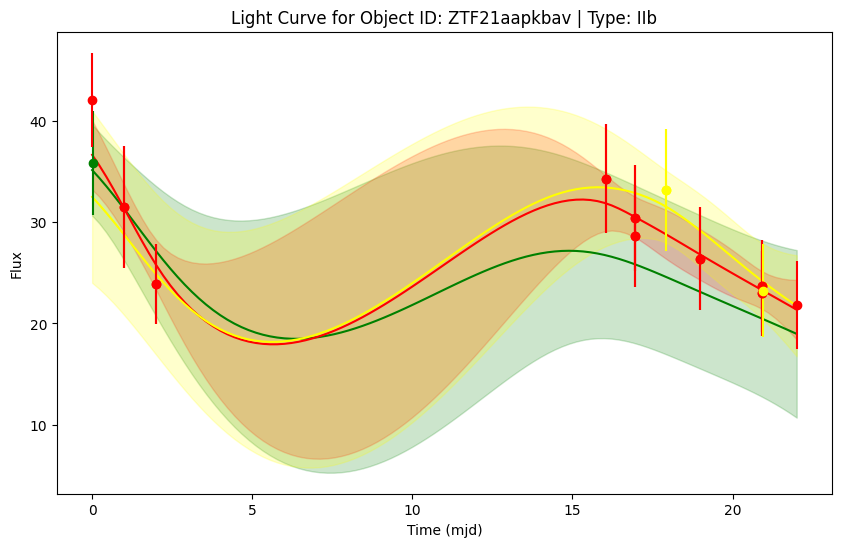

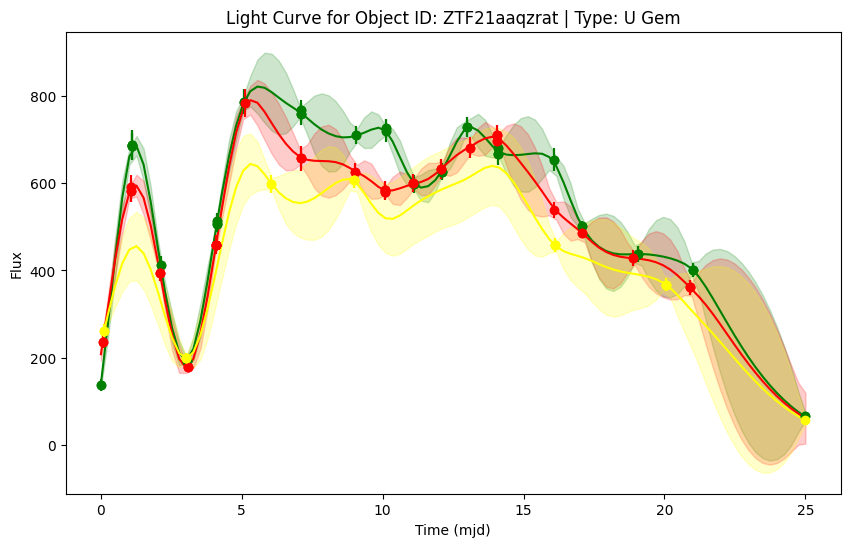

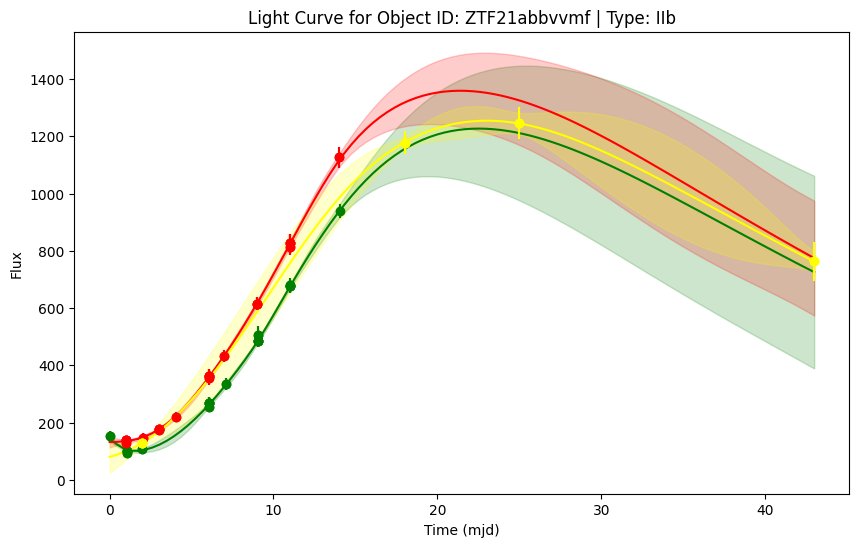

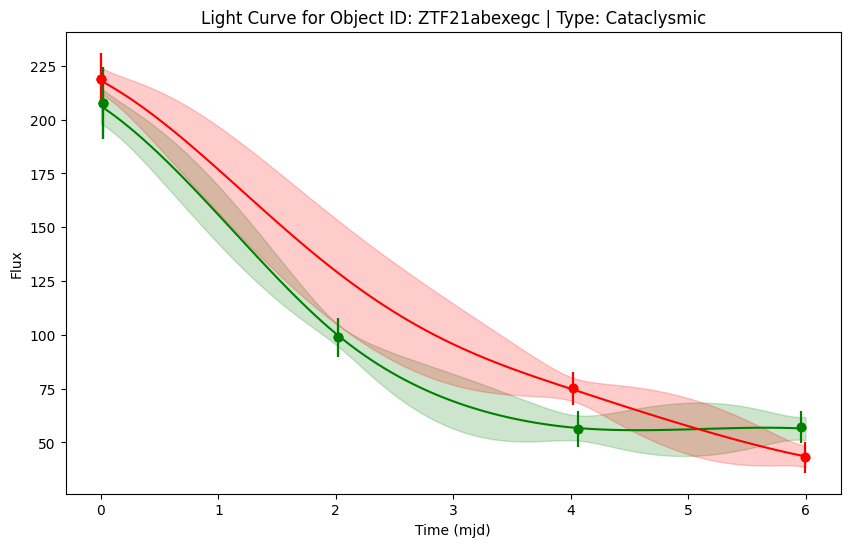

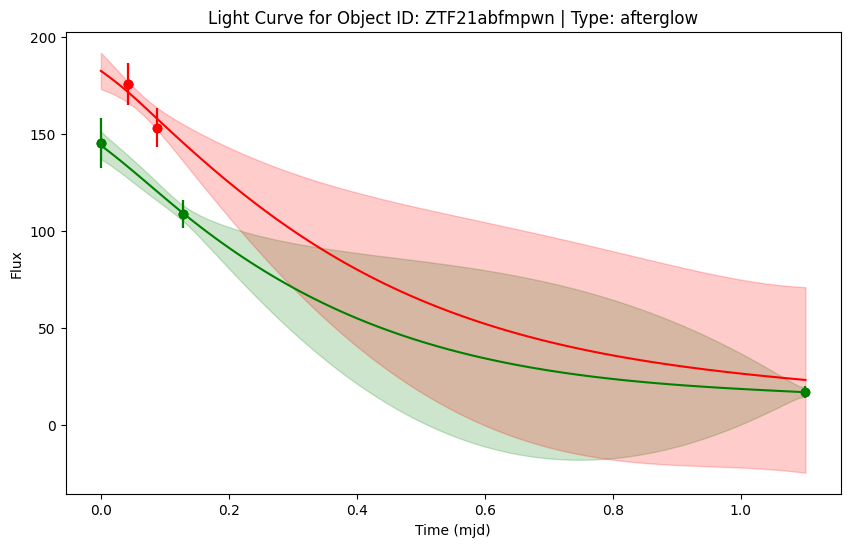

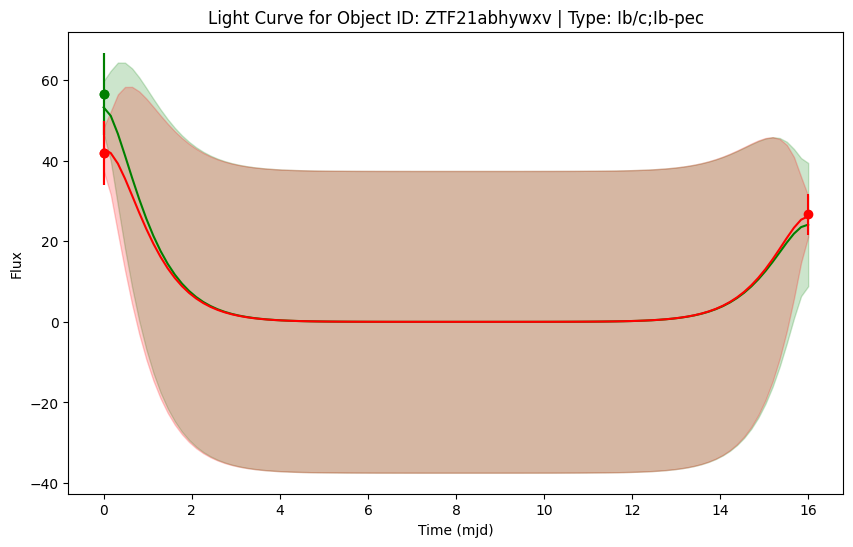

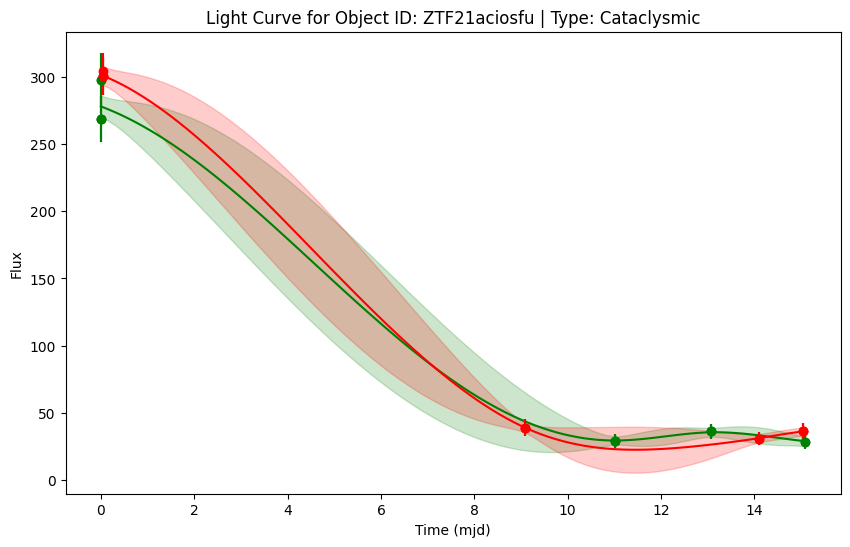

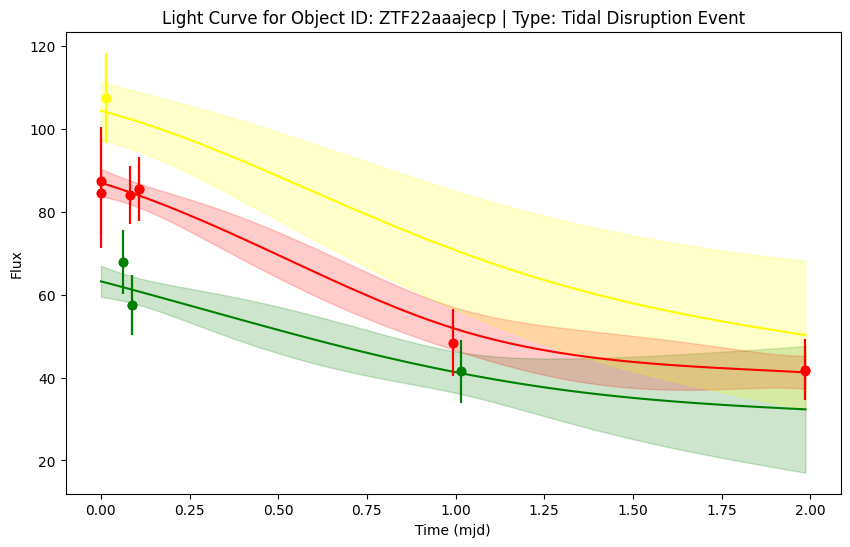

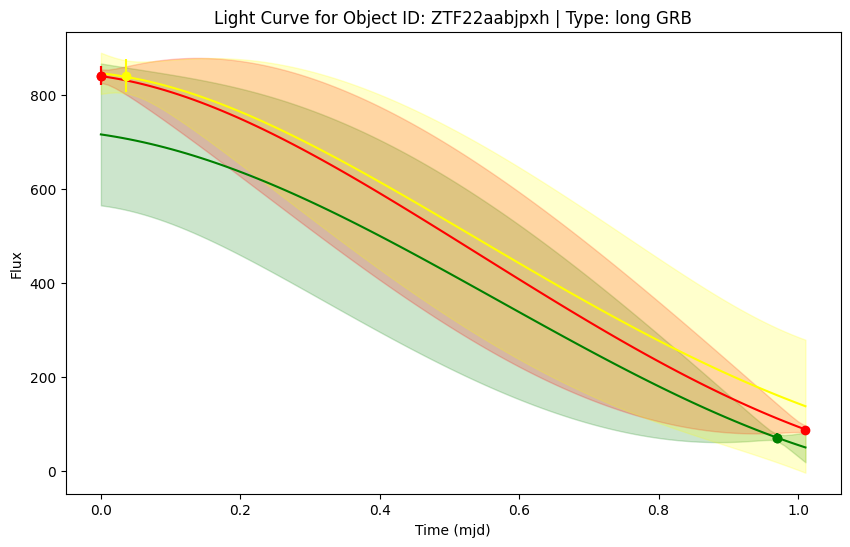

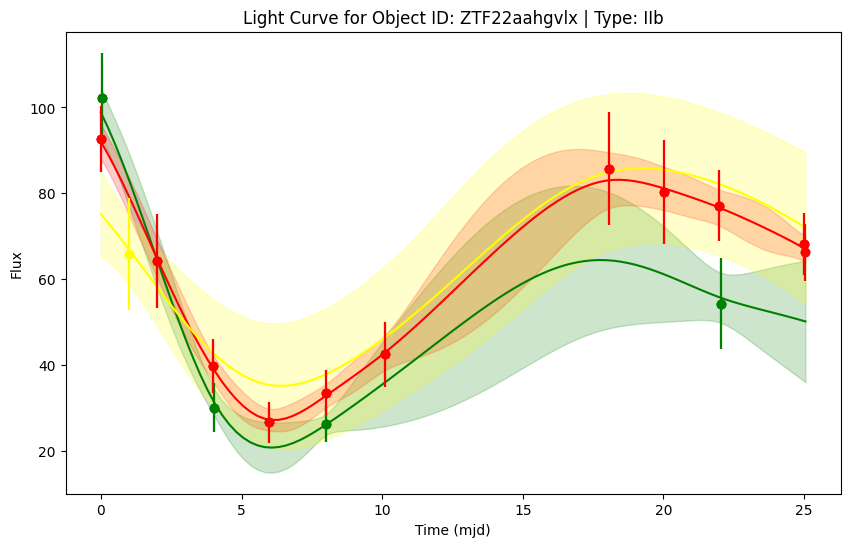

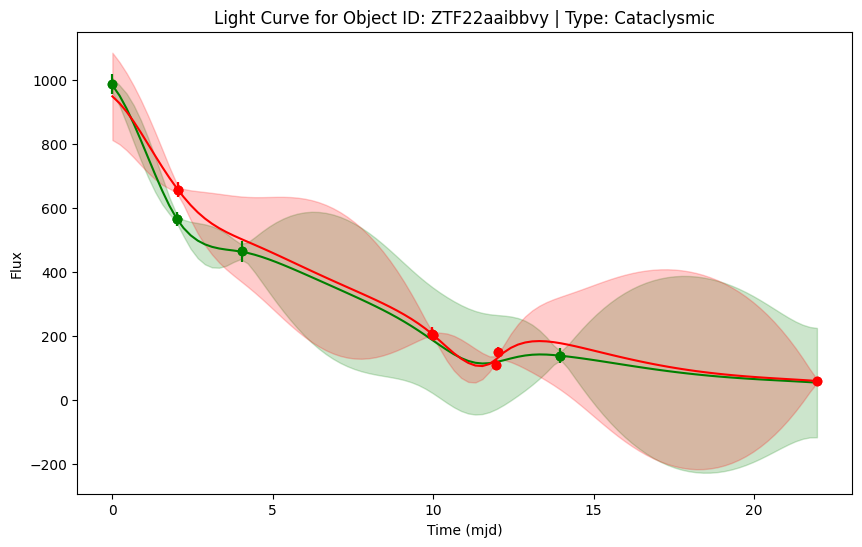

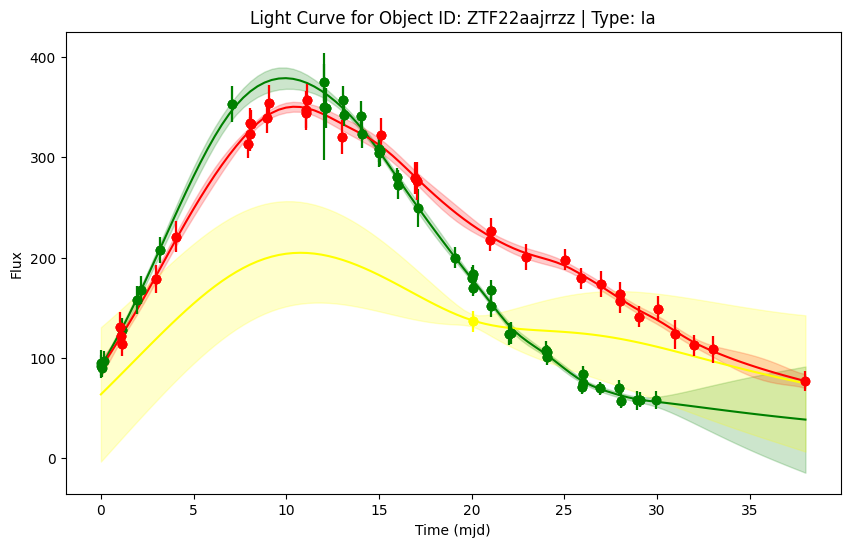

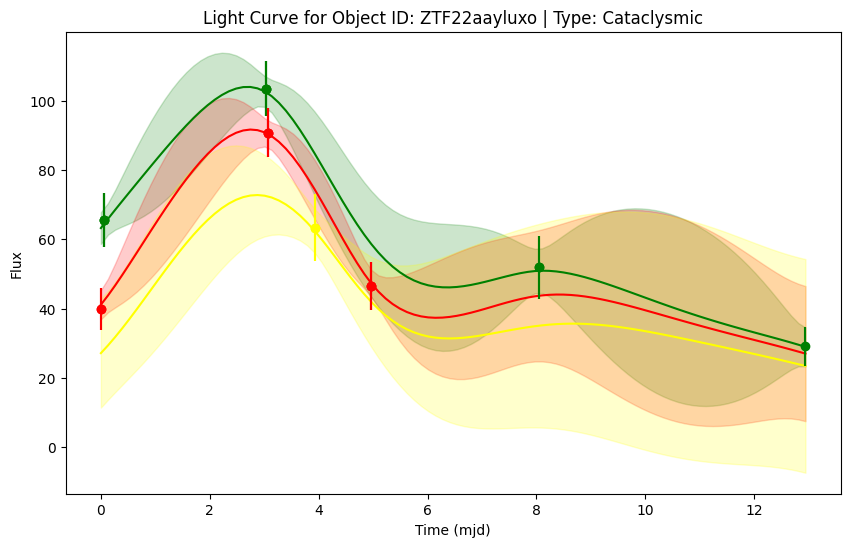

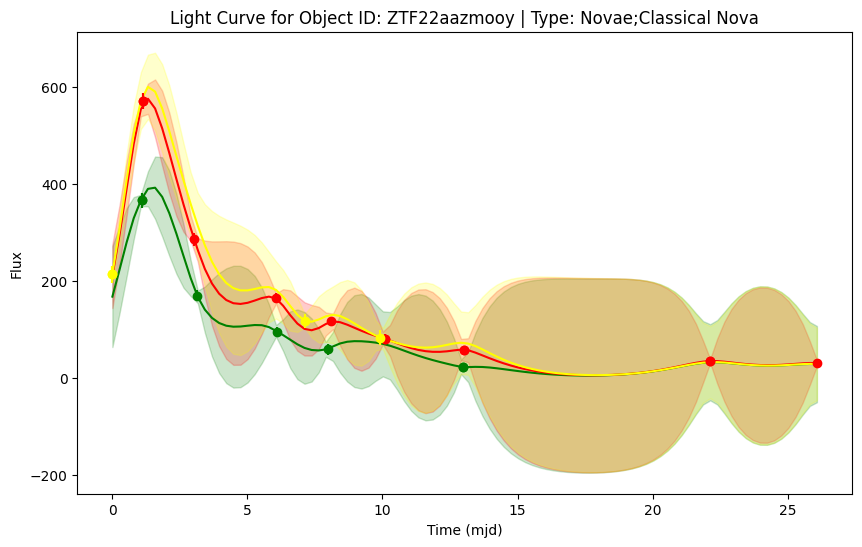

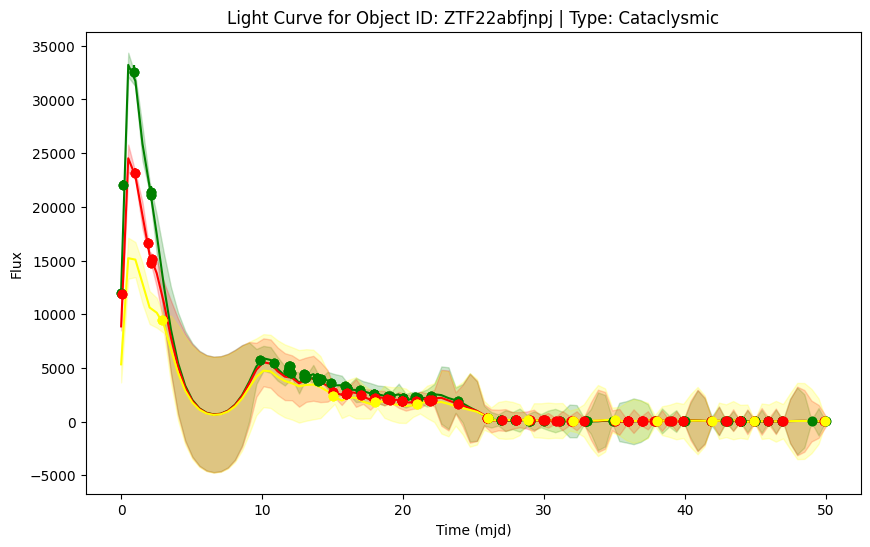

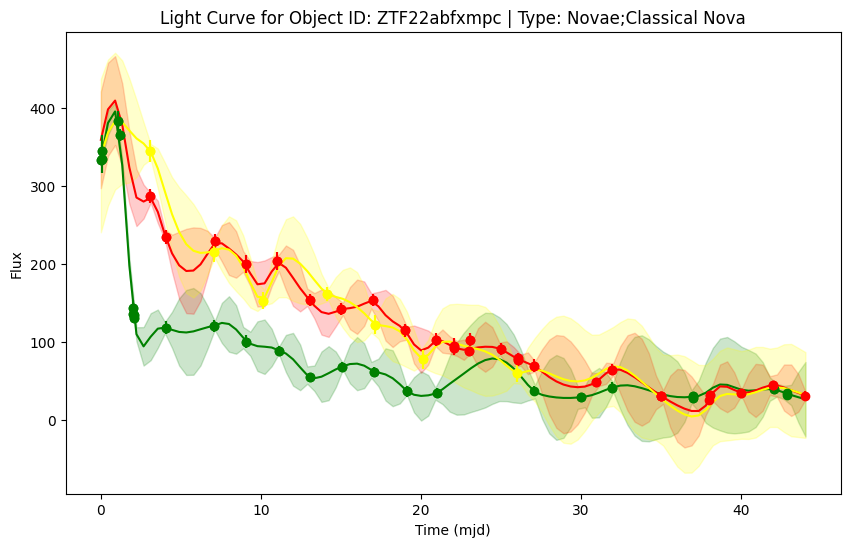

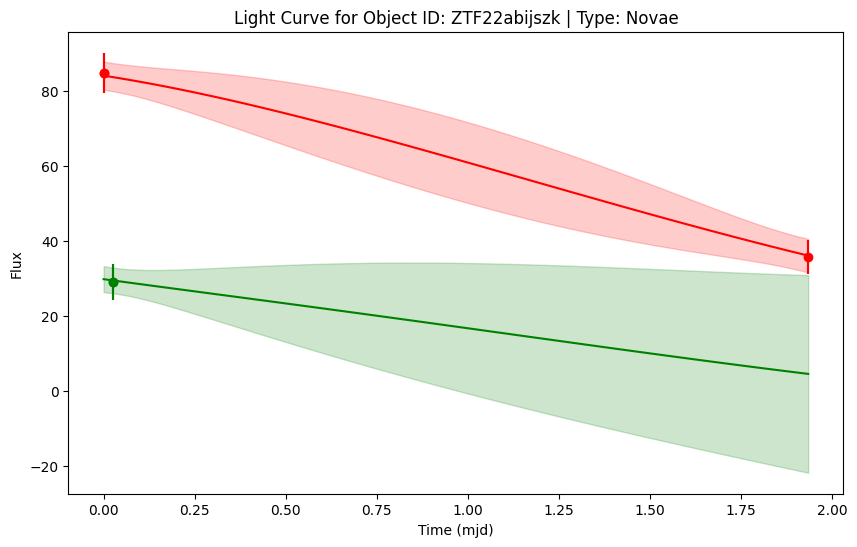

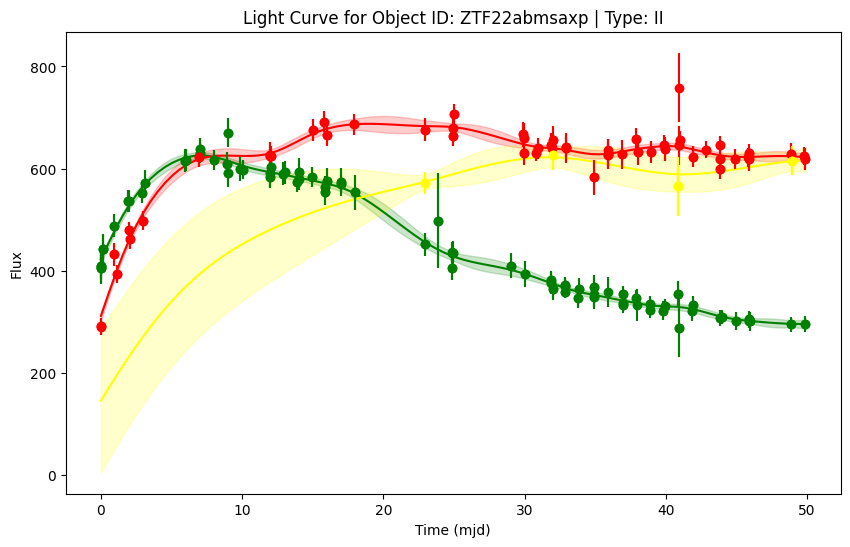

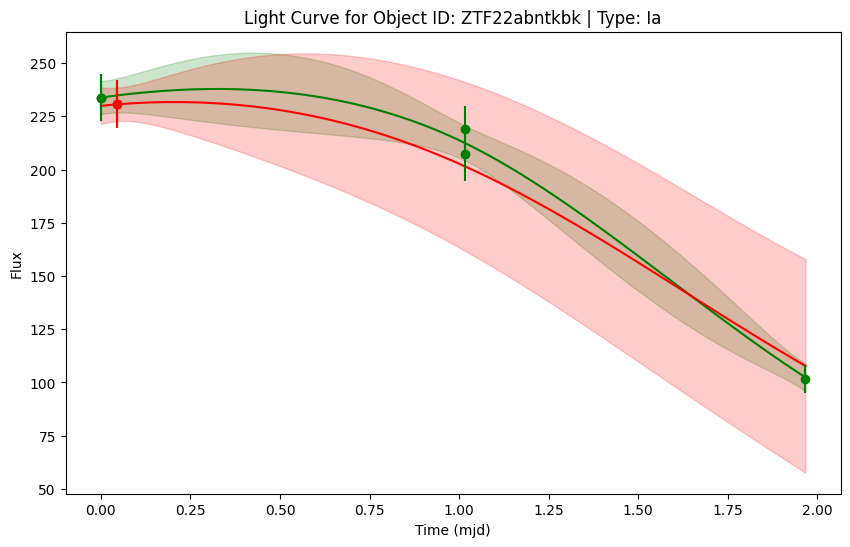

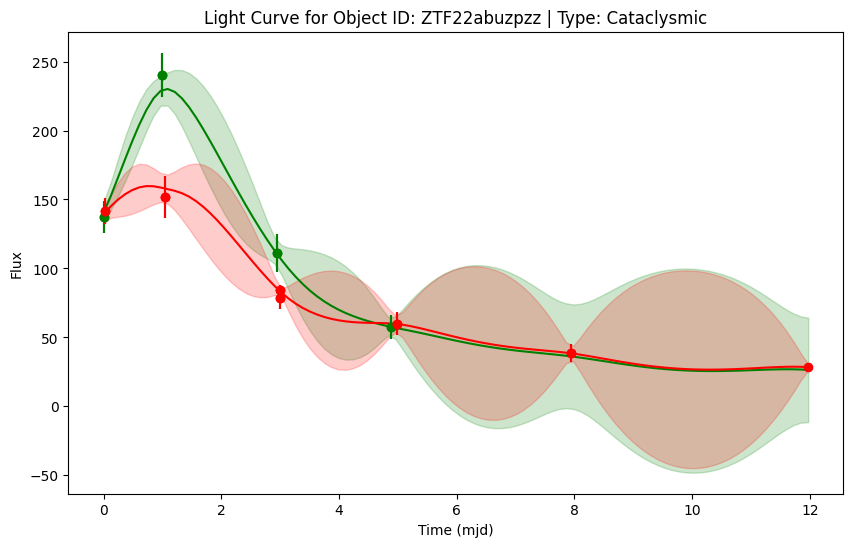

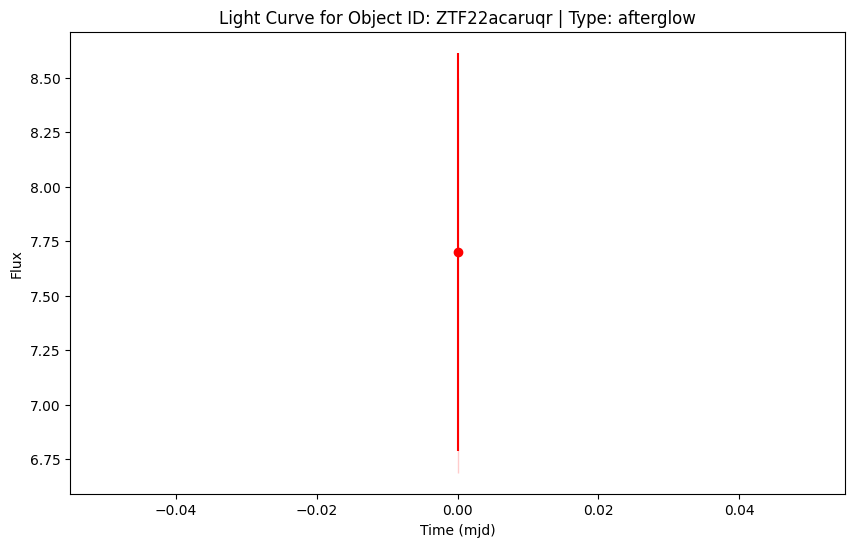

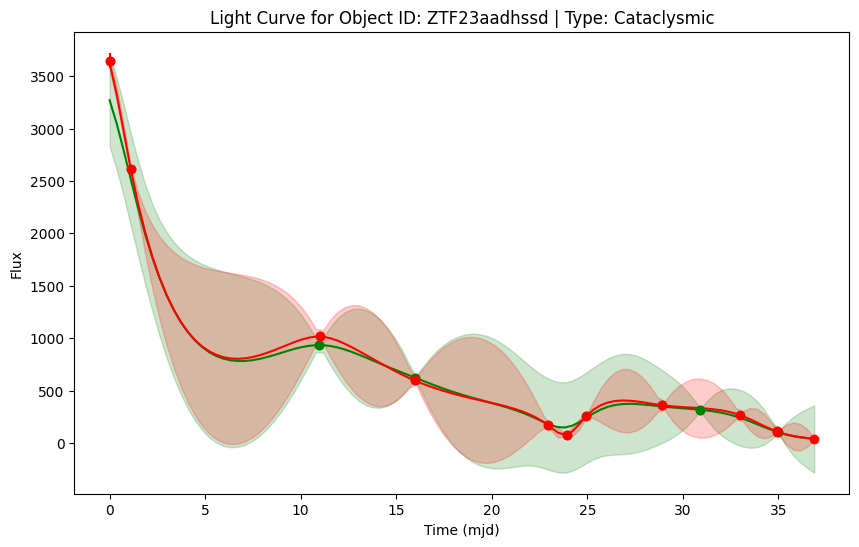

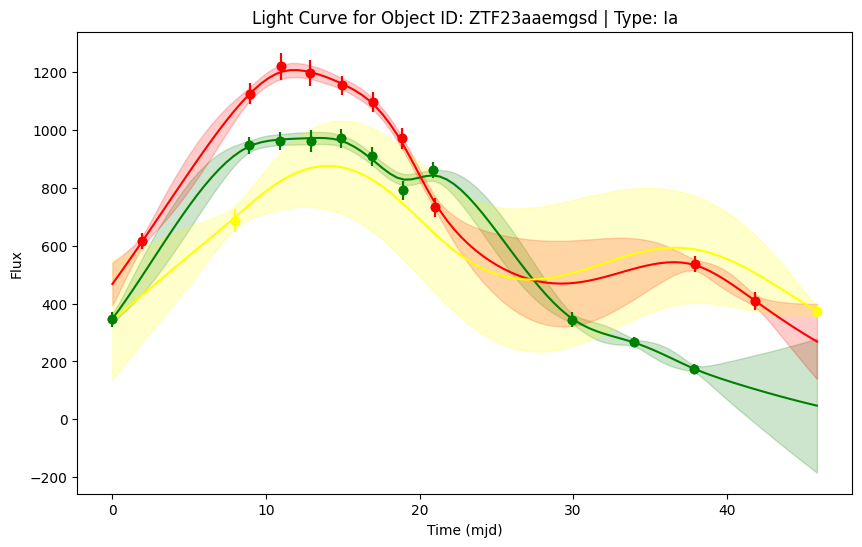

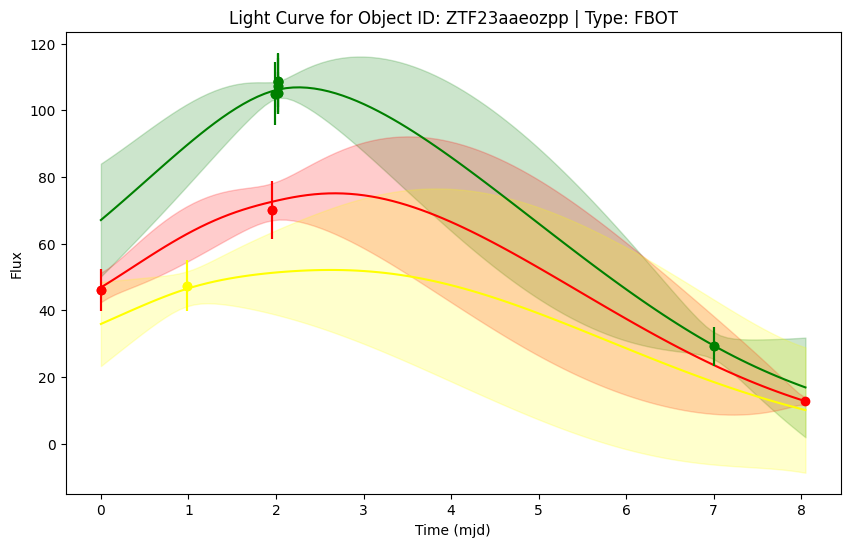

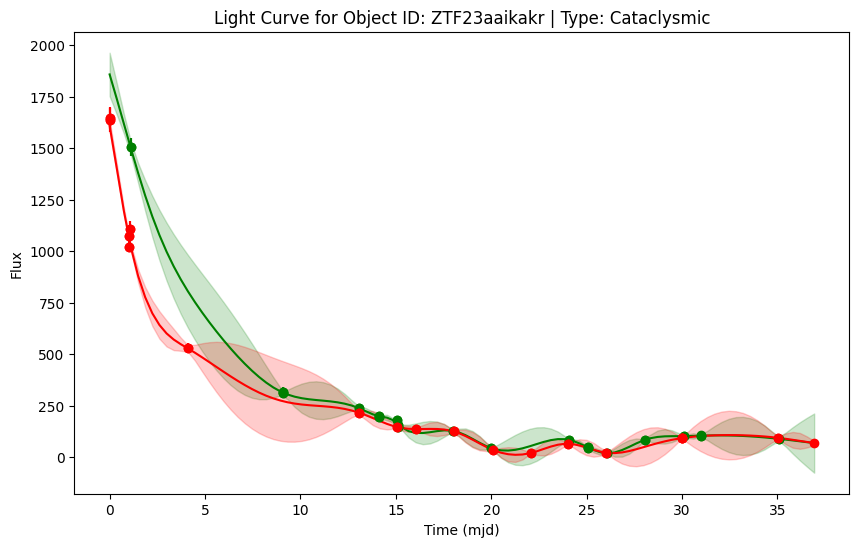

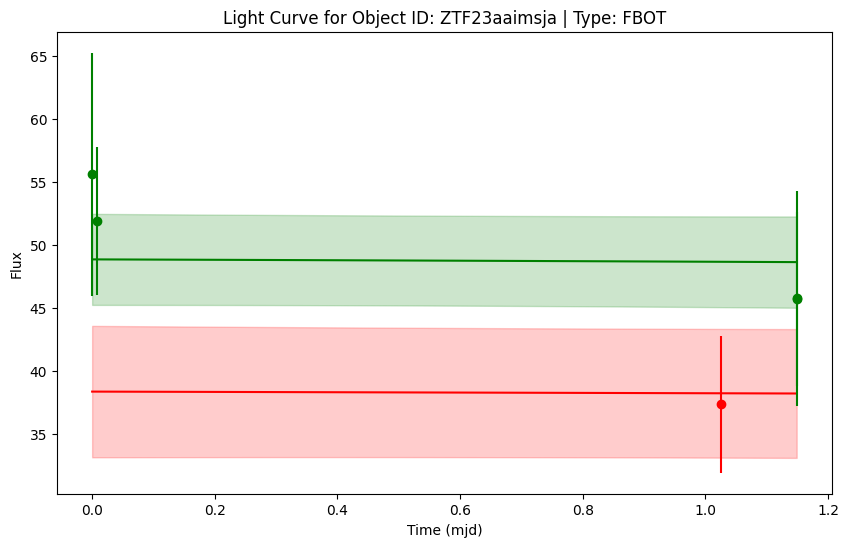

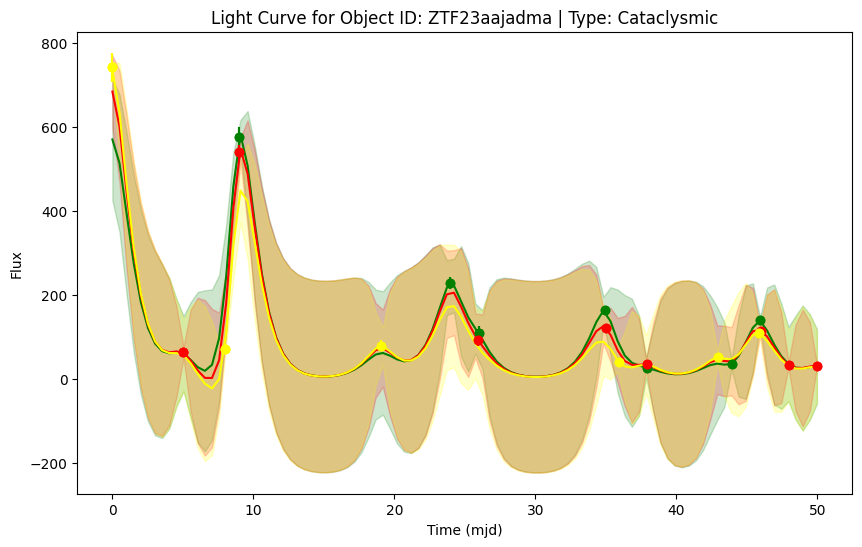

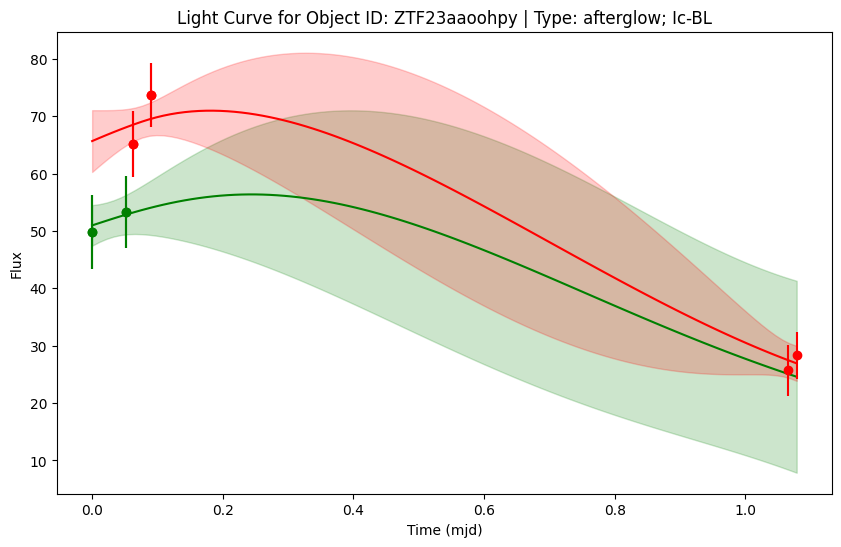

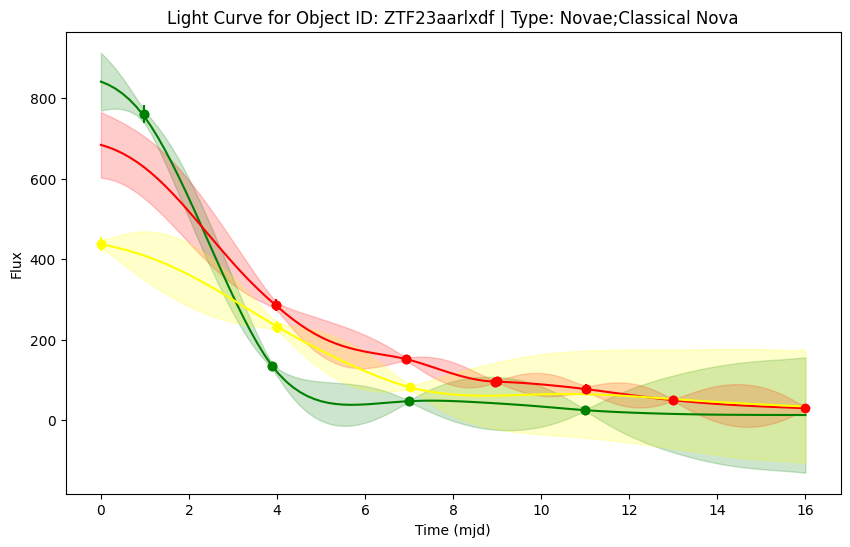

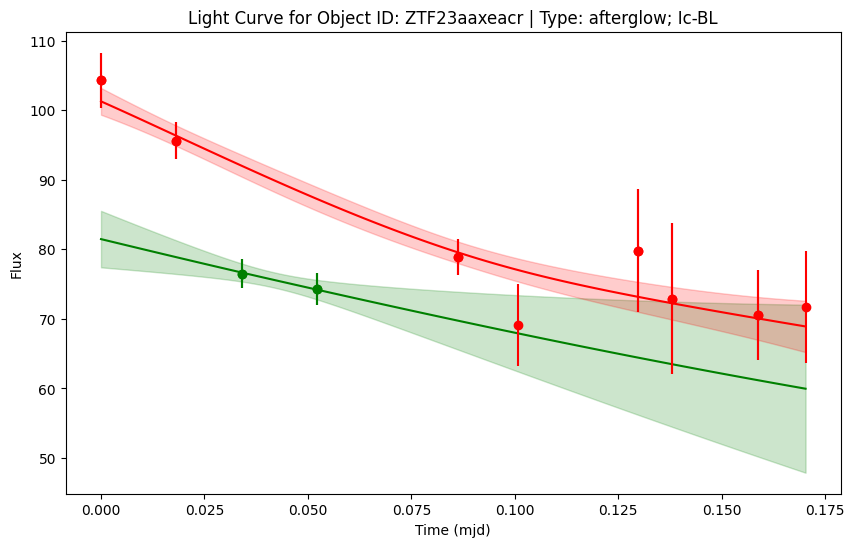

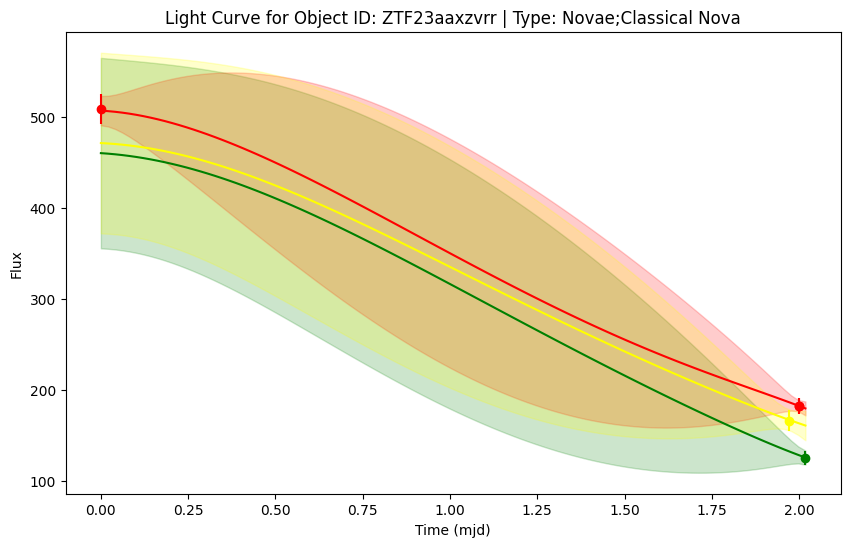

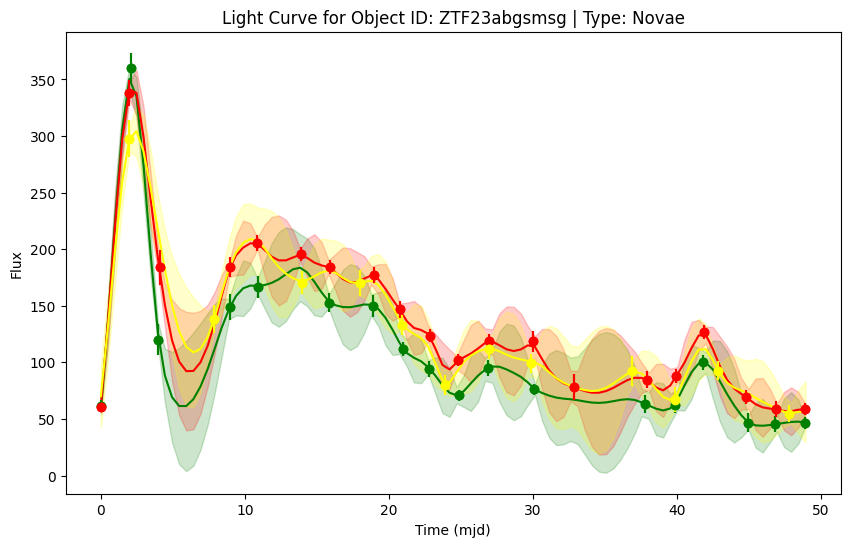

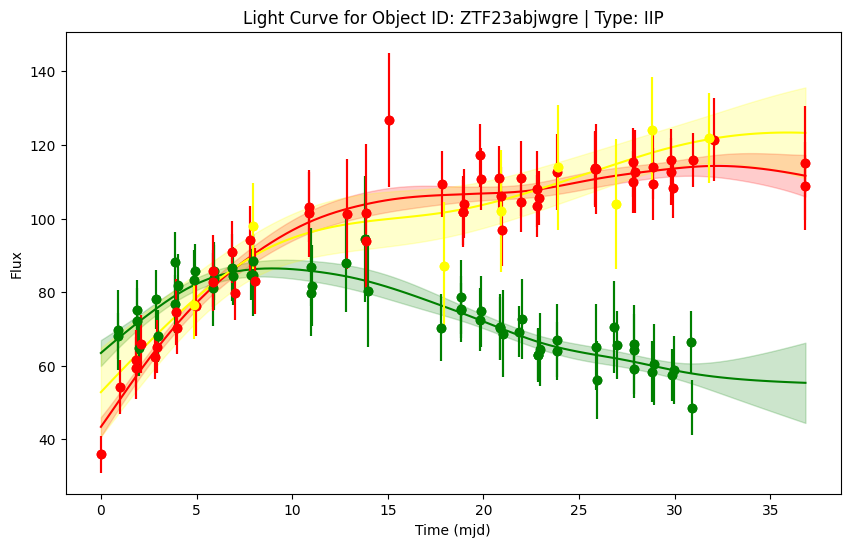

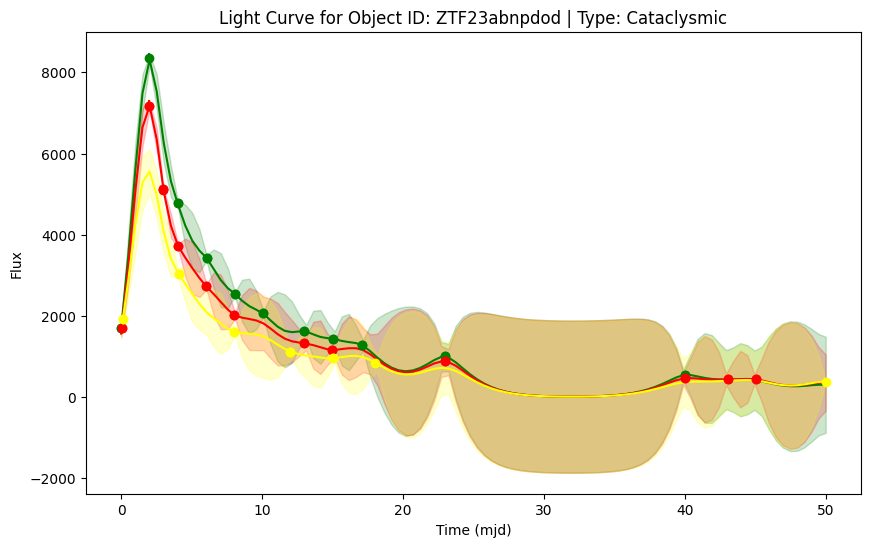

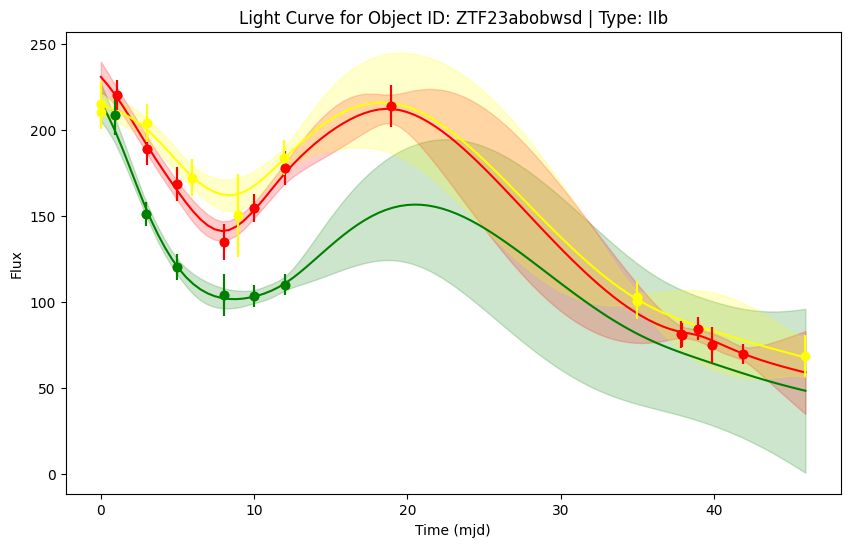

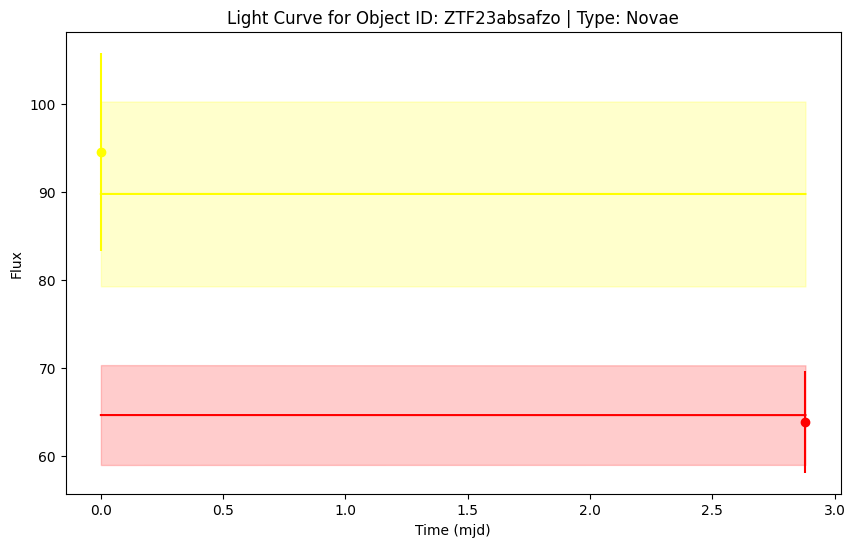

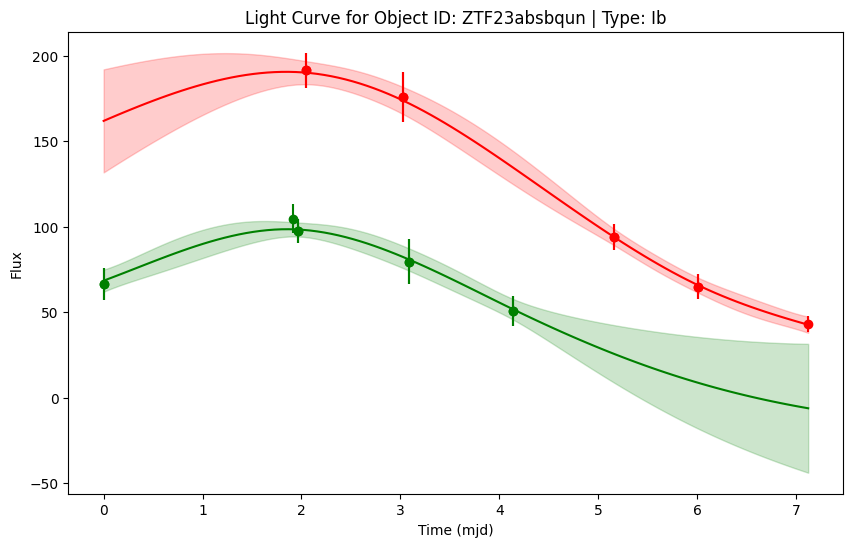

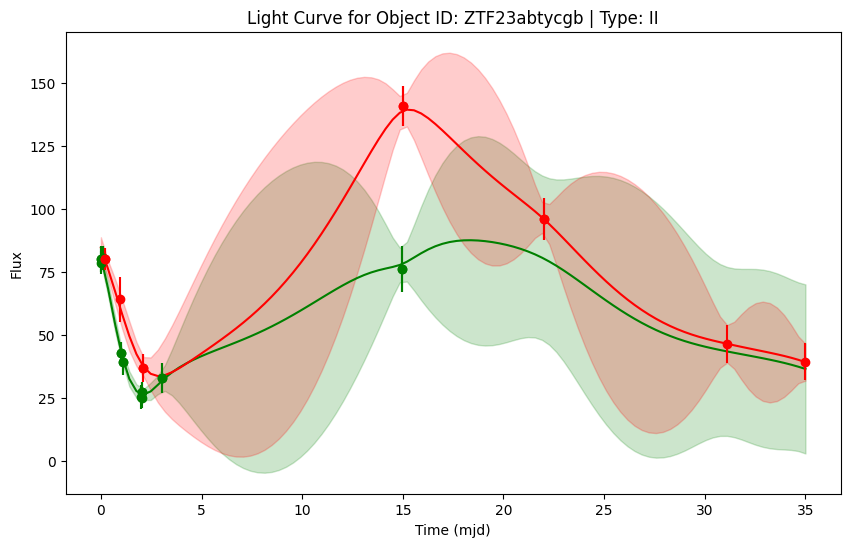

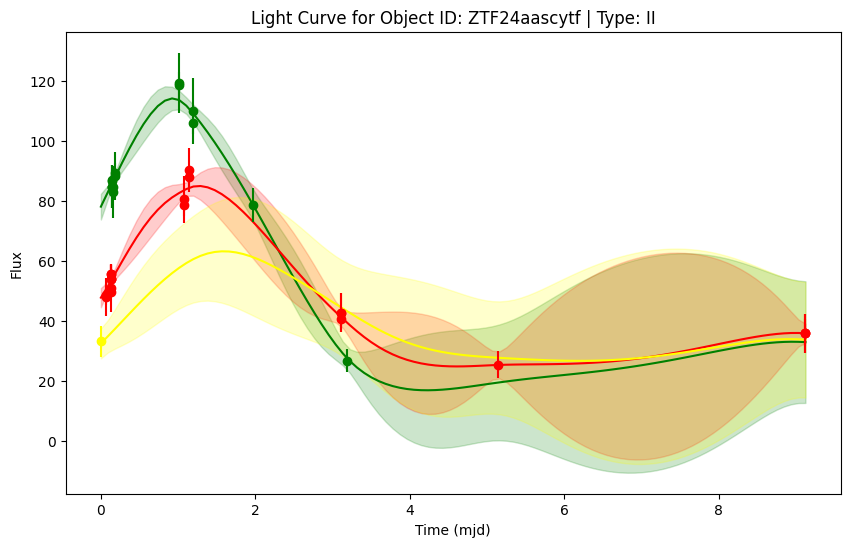

In [21]:
plot_results = total_results
obj_ids = plot_results['obj_id'].unique()
broken_obj_ids = []
for obj in obj_ids:
    one_df = plot_results[plot_results['obj_id'] == obj]
    two_df = norm_df[norm_df['obj_id']==obj]
    two_df = two_df[two_df['mjd']<50]
    fi, axi = plot_gp(one_df, show_legend=False)
    for filter_name in ['ztfg', 'ztfr', 'ztfi']:
        axi.errorbar(two_df[two_df['filter']==filter_name]['mjd'], two_df[two_df['filter']==filter_name]['flux'], yerr=two_df[two_df['filter']==filter_name]['flux_error'], fmt='o', label=f'Observed {filter_name}', color=color_dict[filter_name])
    plt.show()

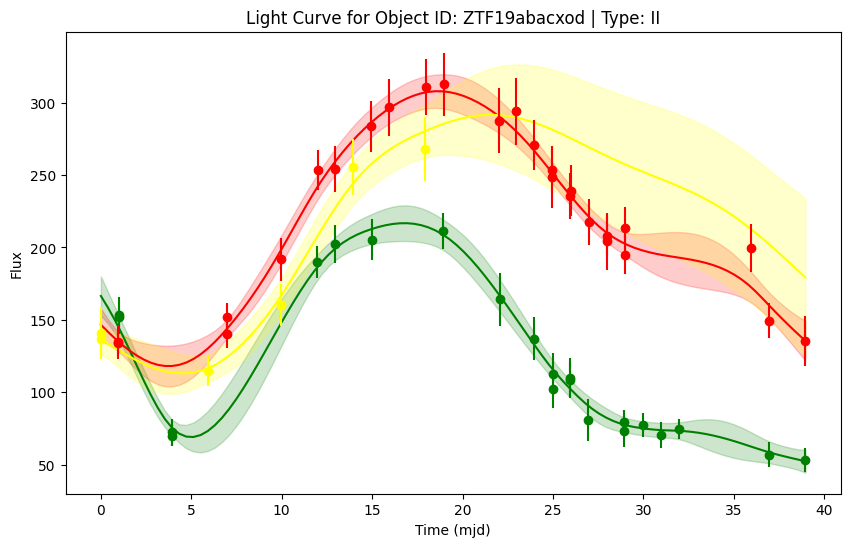

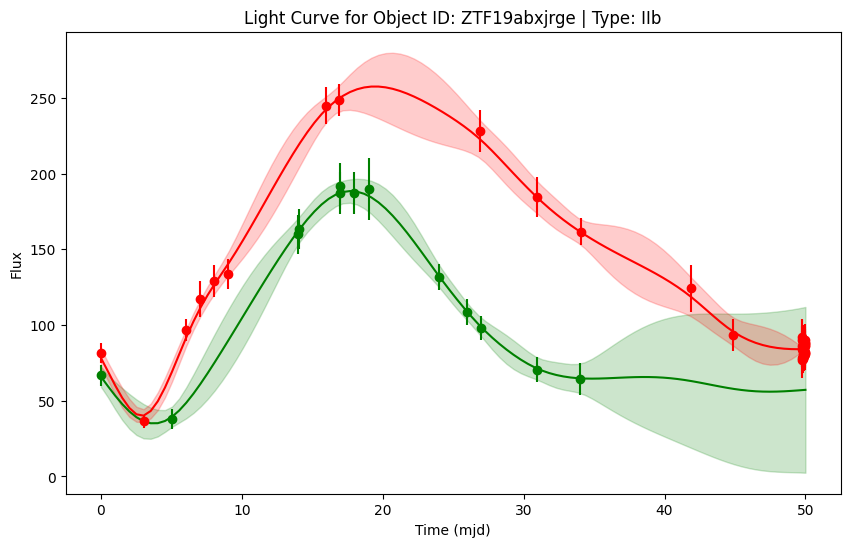

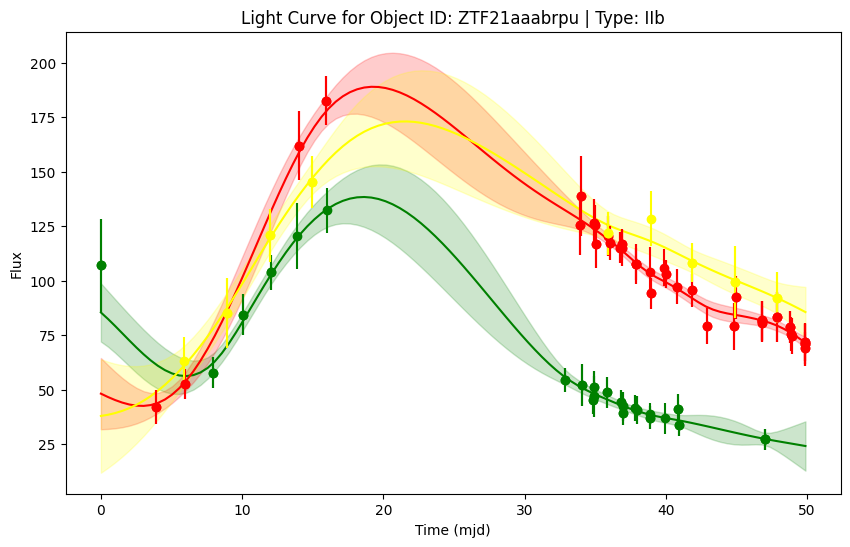

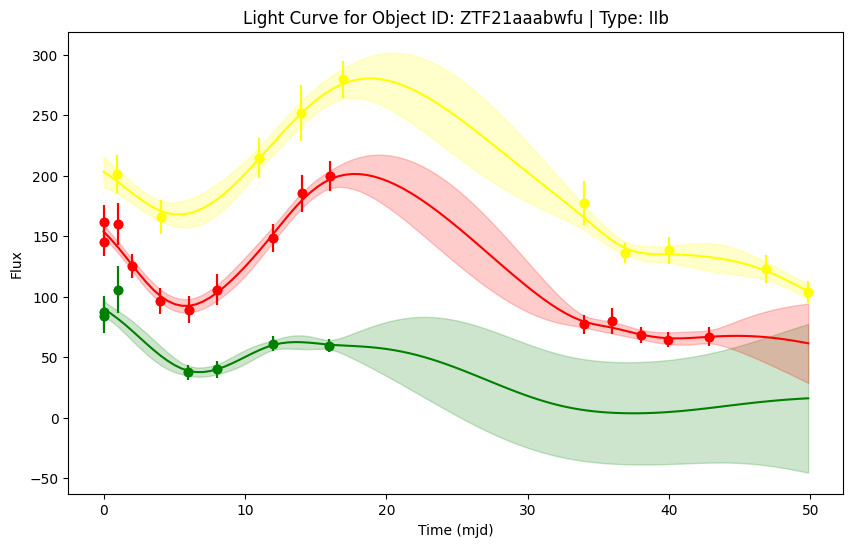

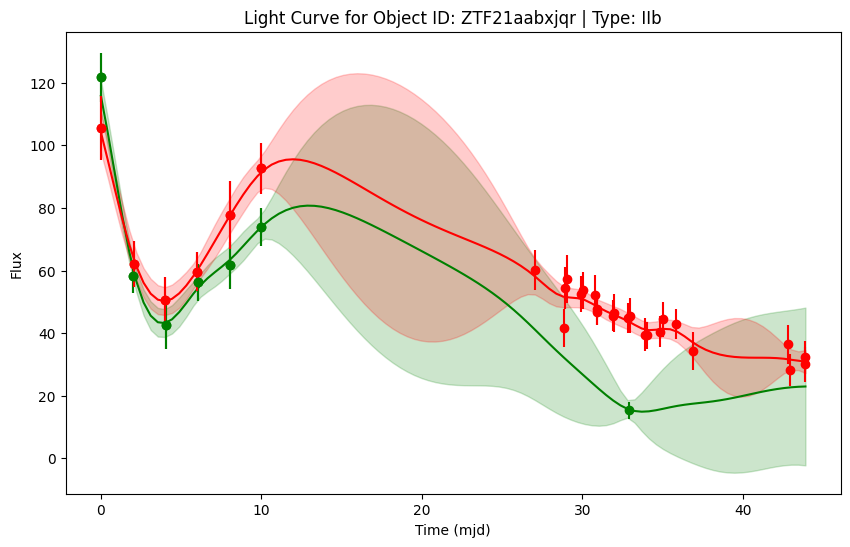

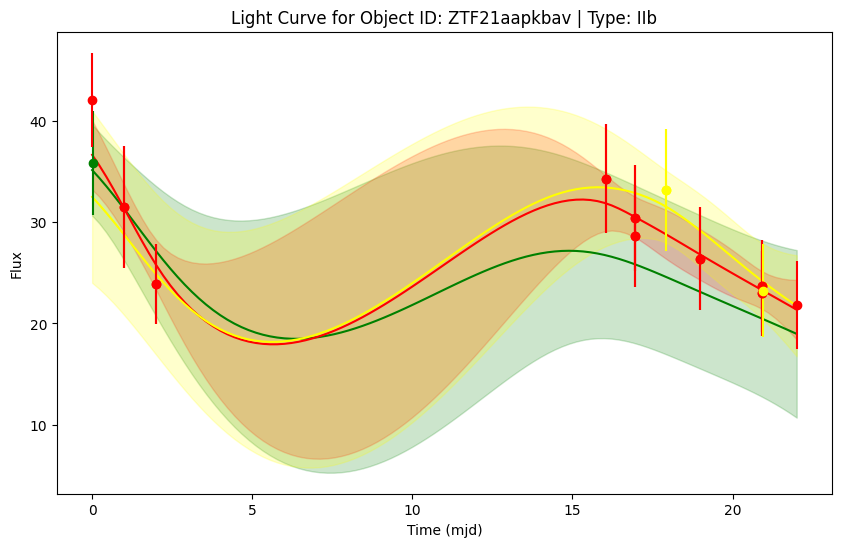

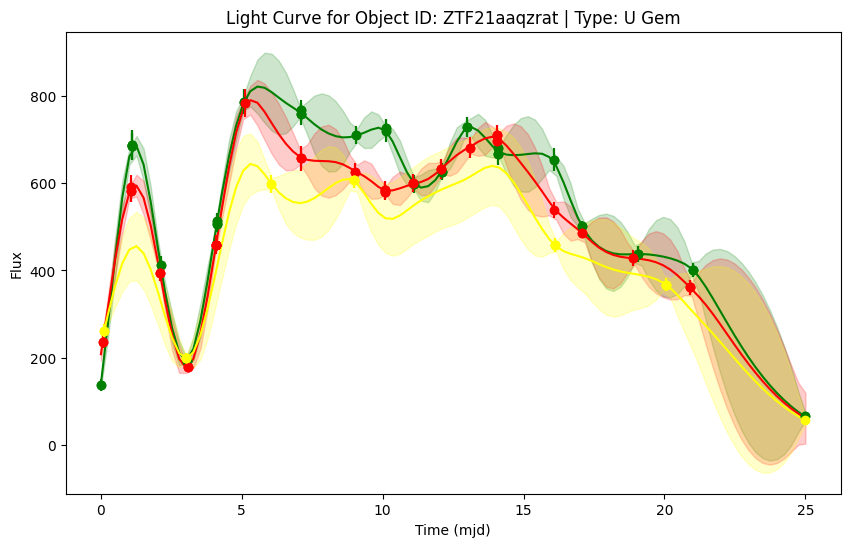

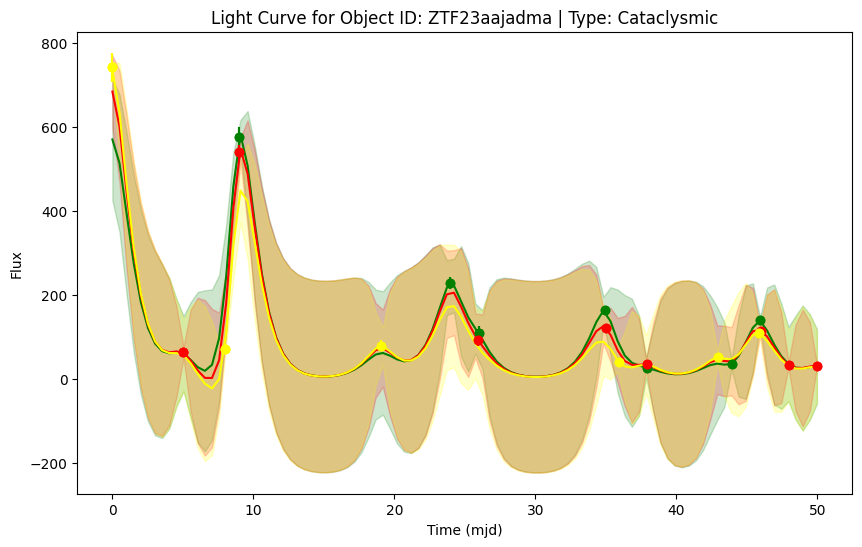

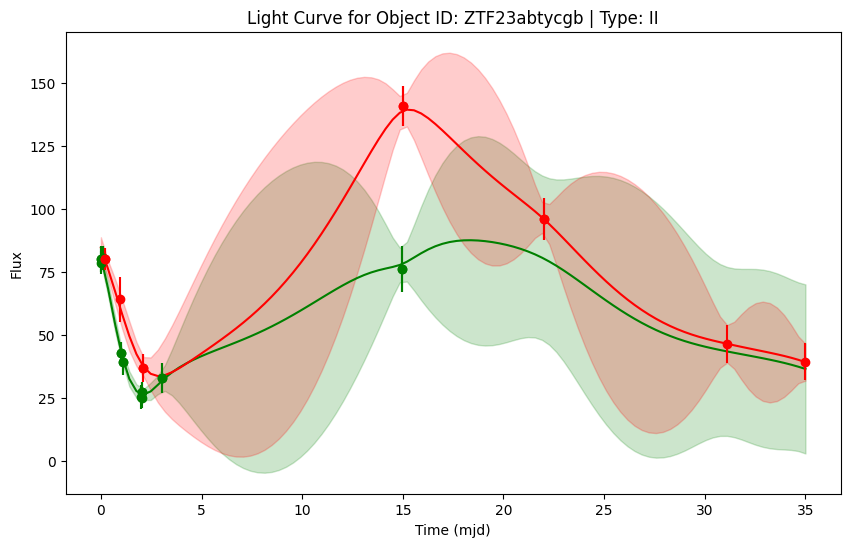

In [22]:
question_objects = ['ZTF19abacxod', 'ZTF19abxjrge', 'ZTF21aaabrpu', 'ZTF21aaabwfu', 'ZTF21aabxjqr', 'ZTF21aapkbav', 'ZTF21aaqzrat', 'ZTF23aajadma', 'ZTF23abtycgb']
for obj in question_objects:
    one_df = plot_results[plot_results['obj_id'] == obj]
    two_df = norm_df[norm_df['obj_id']==obj]
    two_df = two_df[two_df['mjd']<50]
    fi, axi = plot_gp(one_df, show_legend=False)
    for filter_name in ['ztfg', 'ztfr', 'ztfi']:
        axi.errorbar(two_df[two_df['filter']==filter_name]['mjd'], two_df[two_df['filter']==filter_name]['flux'], yerr=two_df[two_df['filter']==filter_name]['flux_error'], fmt='o', label=f'Observed {filter_name}', color=color_dict[filter_name])
    plt.show()

In [23]:
total_results

mjd   flux_ztfg   flux_ztfr  flux_error_ztfg  flux_error_ztfr type  \
0     0.000000  136.476566   99.008275        20.225414         1.245730  Ibn   
1     0.504350  162.972272  126.219481        16.229688         2.778614  Ibn   
2     1.008700  190.825310  153.363912        12.014731         3.524496  Ibn   
3     1.513051  219.423324  180.399970         7.692804         4.826813  Ibn   
4     2.017401  248.089537  206.392050         4.061100         5.478884  Ibn   
...        ...         ...         ...              ...              ...  ...   
7196  8.754780   32.991076   35.778804        22.383172        12.391853   II   
7197  8.846936   33.120805   35.975863        21.500098         9.773389   II   
7198  8.939092   33.177963   36.087816        20.818900         7.085820   II   
7199  9.031247   33.157022   36.099820        20.391462         4.547957   II   
7200  9.123403   33.054302   35.995481        20.256452         3.185979   II   

            obj_id         mjd_0 redshift  flux_ztfi  flux_error_ztfi  
0     ZTF18aakuewf  58226.340532   0.0636        NaN              NaN  
1     ZTF18aakuewf  58226.340532   0.0636        NaN              NaN  
2     ZTF18aakuewf  58226.340532   0.0636        NaN              NaN  
3     ZTF18aakuewf  58226.340532   0.0636        NaN              NaN  
4     ZTF18aakuewf  58226.340532   0.0636        NaN              NaN  
...            ...           ...      ...        ...              ...  
7196  ZTF24aascytf  60476.217836    0.038  33.941007        21.548910  
7197  ZTF24aascytf  60476.217836    0.038  34.034440        20.594324  
7198  ZTF24aascytf  60476.217836    0.038  34.056312        19.852856  
7199  ZTF24aascytf  60476.217836    0.038  34.000498        19.384630  
7200  ZTF24aascytf  60476.217836    0.038  33.862840        19.235181  

[7201 rows x 11 columns]

In [34]:
from astropy.coordinates import Distance
import astropy.units as u
def absmag(m, z):
    '''
    Converts apparent magnitude to absolute magnitude.
    
    Args:
        m (float): apparent magnitude
        z (float): redshift
    '''
    z = float(z)
    if m is None or m is np.nan or z is None or z is np.nan:
        return np.nan
    else:
        if z==0:
            M = m
        elif z < 0:
            M = m
        else:
            d = Distance(unit=u.pc, z=float(z), allow_negative=True)
            M = m - 5 * np.log10(d/(10*u.pc)) + 5
        return M
absmag = np.vectorize(absmag)

def Norm2Mag(df):
    df_copy = df.dropna().copy()
    for filter in ['ztfg', 'ztfr', 'ztfi']:
        df_copy[f'mag_{filter}'] = 23.9 - 2.5 * np.log10(df_copy[f'flux_{filter}'])
        df_copy[f'abs_mag_{filter}'] = absmag(df_copy[f'mag_{filter}'], df_copy['redshift'])
        df_copy[f'mag_error_{filter}'] = 2.5 * df_copy[f'flux_error_{filter}'] / (df_copy[f'flux_{filter}'] * np.log(10))
    df_copy['t'] = df_copy['mjd']
    df_copy['mjd'] = df_copy['mjd'] + df_copy['mjd_0']
    df_copy.reset_index(drop=True, inplace=True)
    return df_copy  

In [37]:
total_mag = Norm2Mag(total_results)
total_mag

/home/tbarna/anaconda3/envs/nmma_env/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/tbarna/anaconda3/envs/nmma_env/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/tbarna/anaconda3/envs/nmma_env/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


mjd   flux_ztfg    flux_ztfr  flux_error_ztfg  flux_error_ztfr  \
0     58602.284734 -666.695160   277.797667       351.800805        14.038662   
1     58602.789692 -555.793423   472.563672       331.949344        32.372399   
2     58603.294651 -444.979452   675.845338       311.863973        52.343606   
3     58603.799610 -336.051590   880.538970       291.227140        64.703163   
4     58604.304568 -230.857697  1079.634322       269.743423        69.221162   
...            ...         ...          ...              ...              ...   
2995  60484.972616   32.991076    35.778804        22.383172        12.391853   
2996  60485.064772   33.120805    35.975863        21.500098         9.773389   
2997  60485.156927   33.177963    36.087816        20.818900         7.085820   
2998  60485.249083   33.157022    36.099820        20.391462         4.547957   
2999  60485.341238   33.054302    35.995481        20.256452         3.185979   

     type        obj_id         mjd_0 redshift    flux_ztfi  ...   mag_ztfg  \
0      Ib  ZTF19aatesgp  58602.284734   0.0043  1504.768428  ...        NaN   
1      Ib  ZTF19aatesgp  58602.284734   0.0043  1662.343466  ...        NaN   
2      Ib  ZTF19aatesgp  58602.284734   0.0043  1816.207652  ...        NaN   
3      Ib  ZTF19aatesgp  58602.284734   0.0043  1963.581138  ...        NaN   
4      Ib  ZTF19aatesgp  58602.284734   0.0043  2101.514219  ...        NaN   
...   ...           ...           ...      ...          ...  ...        ...   
2995   II  ZTF24aascytf  60476.217836    0.038    33.941007  ...  20.104009   
2996   II  ZTF24aascytf  60476.217836    0.038    34.034440  ...  20.099748   
2997   II  ZTF24aascytf  60476.217836    0.038    34.056312  ...  20.097876   
2998   II  ZTF24aascytf  60476.217836    0.038    34.000498  ...  20.098561   
2999   II  ZTF24aascytf  60476.217836    0.038    33.862840  ...  20.101930   

      abs_mag_ztfg  mag_error_ztfg   mag_ztfr  abs_mag_ztfr  mag_error_ztfr  \
0              NaN       -0.572920  17.790679     -8.616242        0.054868   
1              NaN       -0.648459  17.213849     -9.193072        0.074377   
2              NaN       -0.760939  16.825382     -9.581539        0.084089   
3              NaN       -0.940915  16.538129     -9.868792        0.079781   
4              NaN       -1.268618  16.316808    -10.090113        0.069612   
...            ...             ...        ...           ...             ...   
2995    -11.088855        0.736630  20.015935    -11.176929        0.376041   
2996    -11.093116        0.704797  20.009972    -11.182892        0.294957   
2997    -11.094988        0.681291  20.006599    -11.186266        0.213184   
2998    -11.094303        0.667724  20.006237    -11.186627        0.136784   
2999    -11.090934        0.665365  20.009380    -11.183484        0.096099   

       mag_ztfi  abs_mag_ztfi  mag_error_ztfi         t  
0     15.956326    -10.450595        0.154648  0.000000  
1     15.848198    -10.558723        0.119346  0.504959  
2     15.752086    -10.654835        0.089995  1.009917  
3     15.667378    -10.739543        0.065209  1.514876  
4     15.593669    -10.813252        0.044368  2.019834  
...         ...           ...             ...       ...  
2995  20.073188    -11.119676        0.689326  8.754780  
2996  20.070203    -11.122661        0.656982  8.846936  
2997  20.069506    -11.123358        0.632921  8.939092  
2998  20.071287    -11.121577        0.619008  9.031247  
2999  20.075692    -11.117172        0.616733  9.123403  

[3000 rows x 21 columns]

In [38]:
# total_mag.to_csv('gp_objects.csv', index=False)